In [2]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler,label_binarize
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""

'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

In [3]:
# Paso 1: Cargar el dataset
file_path = "faults-10.csv"
df = pd.read_csv(file_path)

In [4]:
# Paso 2: Crear variable 'target' a partir de las columnas one-hot de clase
class_columns = df.columns[-7:]

def obtener_clase_activa(row):
    for col in class_columns:
        if row[col] == 1:
            return str(col)
    return None

df["target"] = df.apply(obtener_clase_activa, axis=1)
df = df.drop(columns=class_columns)

# Paso 3: Separar variables y target
X = df.drop(columns=["target"])
y = df["target"]

# Paso 4: Dividir en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:55:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of 

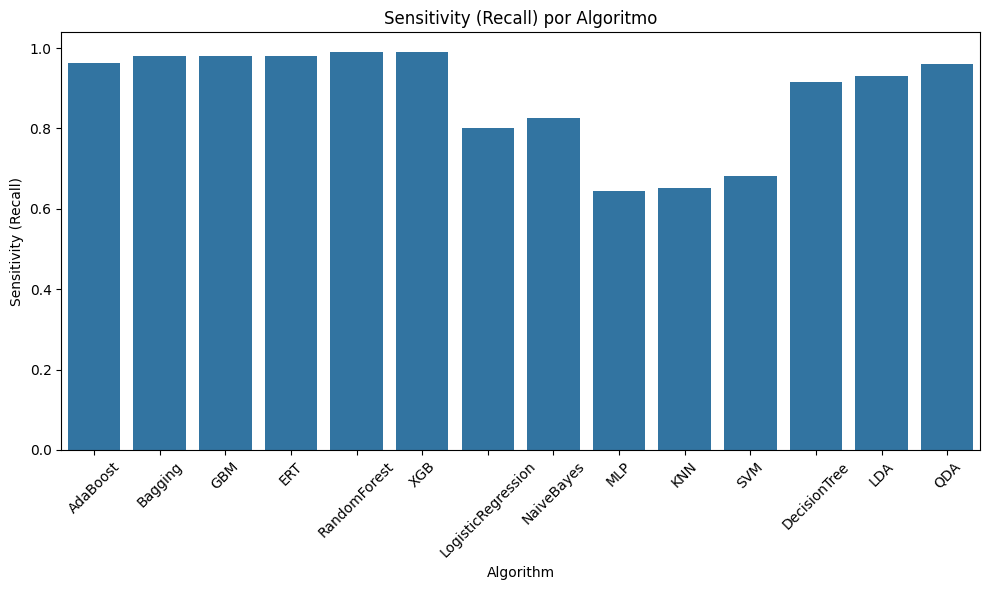

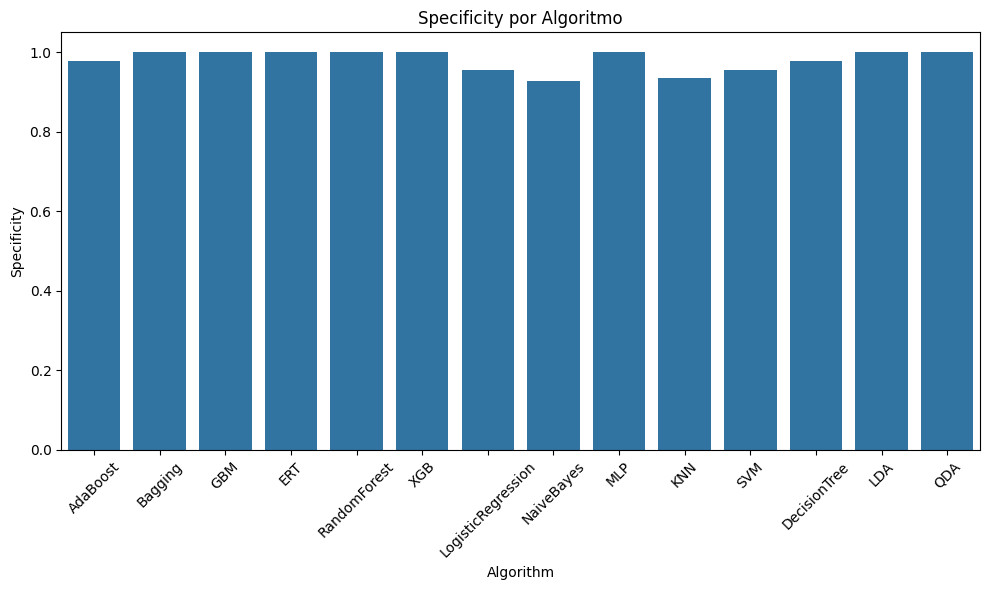

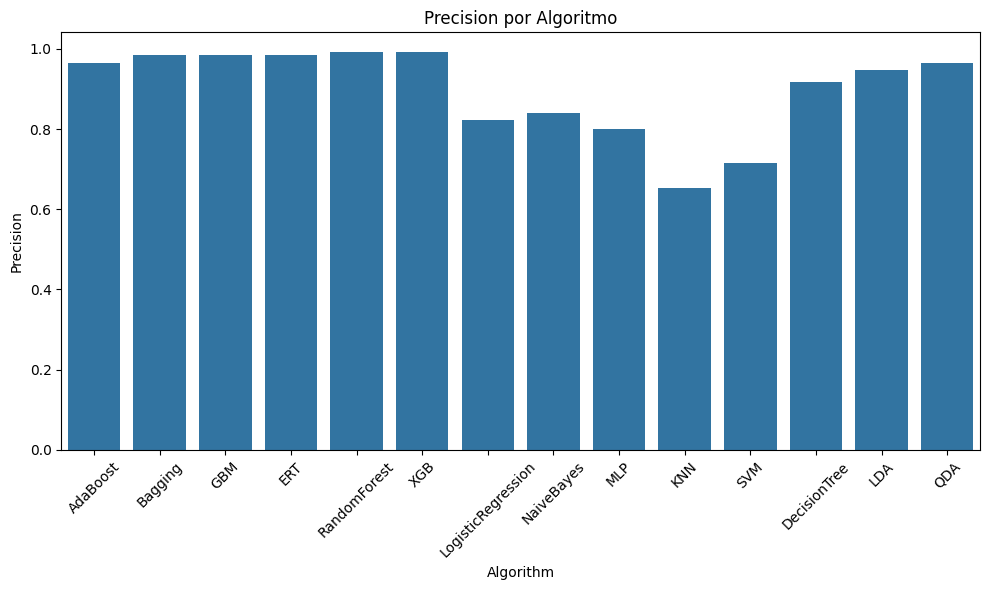

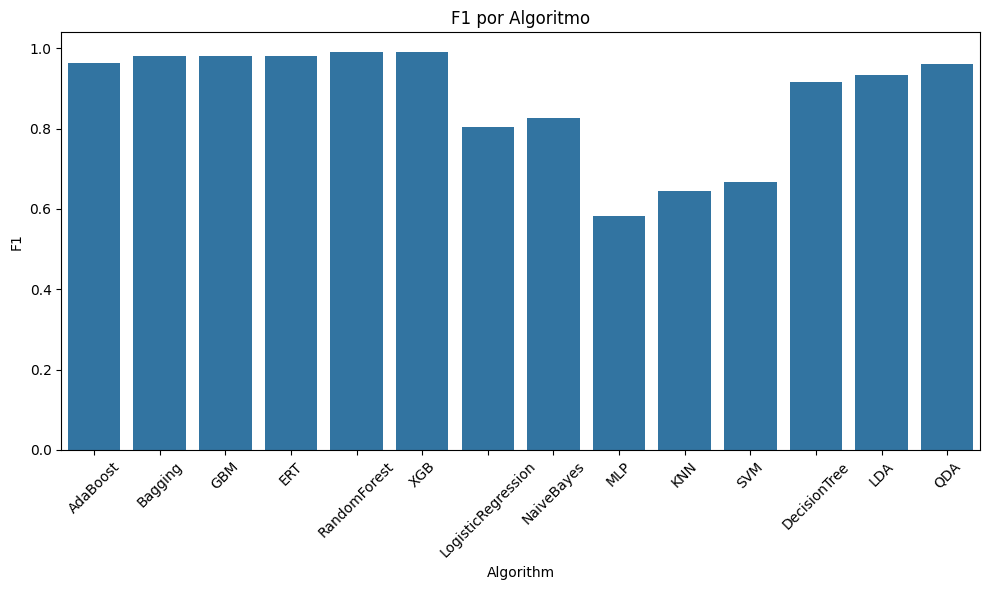

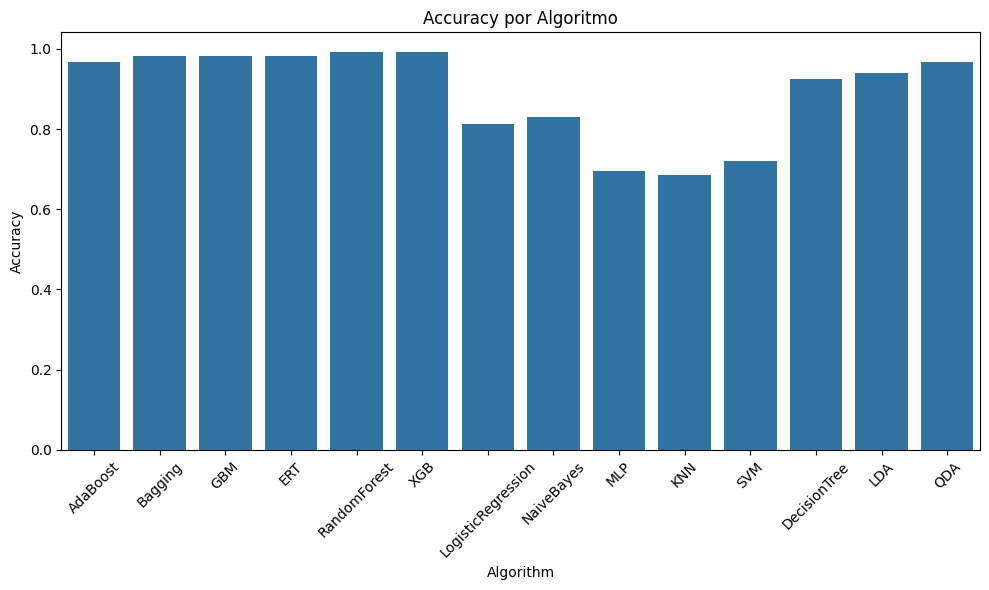

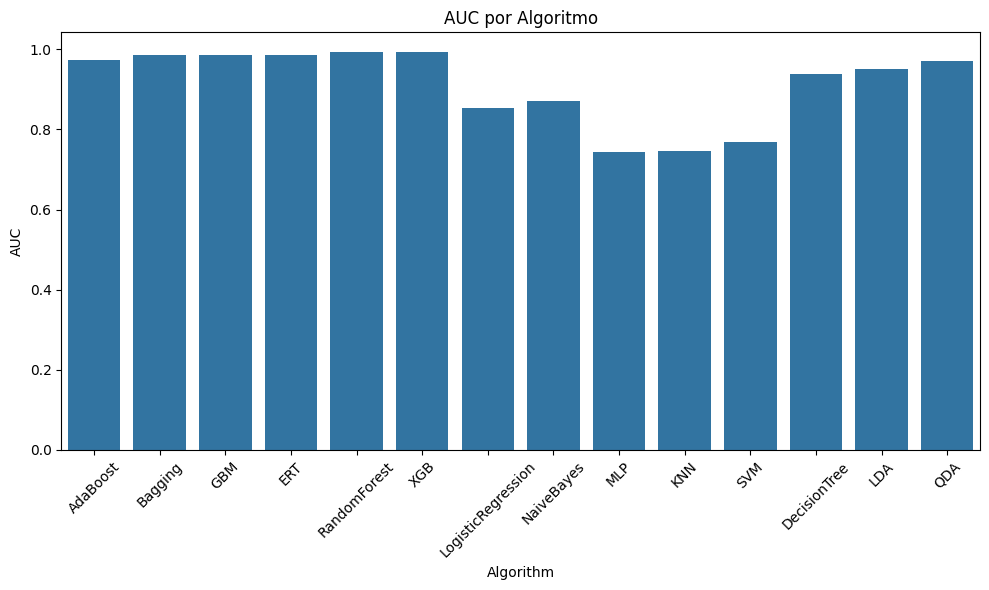

In [5]:
# Convertir etiquetas de clase (strings) a enteros
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)

# Paso 4: Métricas ajustadas a multiclase
def metricas(model_label, y_true, y_pred):
    cm = confusion_matrix(y_valid, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    
    try:
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    except:
        specificity = np.nan

   
    try:
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))
        auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovo')
    except:
        auc = np.nan

    return {
        'Algorithm': model_label,
        'Sensitivity (Recall)': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC':auc
    }


# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

# Entrenar modelos

X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

results = []

for model_label, model in models.items():
    model.fit(X_train_np, y_train_enc)
    y_pred = model.predict(X_valid_np)
    y_pred_decoded = le.inverse_transform(y_pred)
    result = metricas(model_label, y_valid, y_pred_decoded)
    results.append(result)

df_results = pd.DataFrame(results)

# Paso 6: Visualización de métricas
metrics = ['Sensitivity (Recall)','Specificity', 'Precision', 'F1', 'Accuracy','AUC']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} por Algoritmo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, cohen_kappa_score
)
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le_repeated = LabelEncoder()
y_encoded = le_repeated.fit_transform(y)

def repeated_cv_metrics(model, X, y, n_repeats=20, n_splits=4, seed_base=42):
    metrics = {
        'accuracy': [], 'precision': [], 'recall': [], 'specificity': [],
        'f1': [], 'auc': [], 'mcc': [], 'kappa': []
    }
    
    for i in range(n_repeats):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_base + i)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
           # y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

            cm = confusion_matrix(y_test, y_pred)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            else:
                specificities = []
                for j in range(cm.shape[0]):
                    tn = cm.sum() - (cm[j, :].sum() + cm[:, j].sum() - cm[j, j])
                    fp = cm[:, j].sum() - cm[j, j]
                    specificity_i = tn / (tn + fp) if (tn + fp) > 0 else 0
                    specificities.append(specificity_i)
                specificity = np.mean(specificities)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            metrics['recall'].append(recall_score(y_test, y_pred, average='macro'))
            metrics['specificity'].append(specificity)  
            metrics['f1'].append(f1_score(y_test, y_pred, average='macro'))
          
            if y_proba is not None and not np.isnan(y_proba).any():
                try:
                    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
                except ValueError:
                    auc_score = np.nan
            else:
                auc_score = np.nan
            metrics['auc'].append(auc_score)
            
            metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
            metrics['kappa'].append(cohen_kappa_score(y_test, y_pred))
    return pd.DataFrame(metrics)


In [7]:

# Evaluación con validación cruzada repetida
resultados_repetidos = {}

for model_label, model in models.items():
    print(f"Evaluando (repetido): {model_label}") 
    df_metrics = repeated_cv_metrics(model, X, y_encoded, n_repeats=20, n_splits=4)
    df_metrics["modelo"] = model_label
    resultados_repetidos[model_label] = df_metrics

df_resultados_repetidos = pd.concat(resultados_repetidos.values(), ignore_index=True)


Evaluando (repetido): AdaBoost
Evaluando (repetido): Bagging
Evaluando (repetido): GBM
Evaluando (repetido): ERT
Evaluando (repetido): RandomForest
Evaluando (repetido): XGB


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:58:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:58:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:58:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:58:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando (repetido): LogisticRegression


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando (repetido): NaiveBayes
Evaluando (repetido): MLP
Evaluando (repetido): KNN
Evaluando (repetido): SVM
Evaluando (repetido): DecisionTree
Evaluando (repetido): LDA
Evaluando (repetido): QDA


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of param

In [8]:
# Tabla resumen por modelo con media y desviación estándar
resumen_repetido = df_resultados_repetidos.groupby("modelo").agg(['mean', 'std']).round(4)
display(resumen_repetido)


accuracy         precision          recall          \
                       mean     std      mean     std    mean     std   
modelo                                                                  
AdaBoost             0.9277  0.0230    0.9238  0.0227  0.9256  0.0225   
Bagging              0.9517  0.0196    0.9504  0.0200  0.9482  0.0211   
DecisionTree         0.9391  0.0207    0.9367  0.0210  0.9337  0.0221   
ERT                  0.9723  0.0137    0.9703  0.0146  0.9715  0.0140   
GBM                  0.9806  0.0106    0.9792  0.0107  0.9794  0.0118   
KNN                  0.6349  0.0309    0.6028  0.0349  0.6017  0.0318   
LDA                  0.9394  0.0192    0.9397  0.0197  0.9335  0.0205   
LogisticRegression   0.8111  0.0352    0.8107  0.0366  0.7986  0.0368   
MLP                  0.5786  0.0471    0.4753  0.1135  0.5490  0.0383   
NaiveBayes           0.8089  0.0266    0.8232  0.0254  0.8157  0.0272   
QDA                  0.9545  0.0193    0.9514  0.0202  0.9548  0.0193   
RandomForest         0.9691  0.0143    0.9677  0.0151  0.9681  0.0143   
SVM                  0.6607  0.0298    0.6627  0.0584  0.6215  0.0322   
XGB                  0.9778  0.0108    0.9766  0.0113  0.9766  0.0113   

                   specificity              f1             auc          \
                          mean     std    mean     std    mean     std   
modelo                                                                   
AdaBoost                0.9652  0.0111  0.9232  0.0234  0.9862  0.0060   
Bagging                 0.9759  0.0098  0.9484  0.0211  0.9920  0.0061   
DecisionTree            0.9700  0.0104  0.9340  0.0219  0.9518  0.0162   
ERT                     0.9865  0.0067  0.9706  0.0144  0.9982  0.0012   
GBM                     0.9906  0.0054  0.9790  0.0113  0.9989  0.0012   
KNN                     0.8163  0.0154  0.5971  0.0328  0.8129  0.0230   
LDA                     0.9699  0.0095  0.9351  0.0204  0.9915  0.0051   
LogisticRegression      0.9073  0.0174  0.7986  0.0373  0.9132  0.0257   
MLP                     0.7911  0.0225  0.4709  0.0533  0.6828  0.0346   
NaiveBayes              0.9067  0.0131  0.8091  0.0271  0.9345  0.0186   
QDA                     0.9781  0.0093  0.9523  0.0202  0.9877  0.0077   
RandomForest            0.9848  0.0070  0.9674  0.0150  0.9980  0.0015   
SVM                     0.8266  0.0160  0.5967  0.0412  0.8261  0.0196   
XGB                     0.9891  0.0054  0.9763  0.0113  0.9989  0.0009   

                       mcc           kappa          
                      mean     std    mean     std  
modelo                                              
AdaBoost            0.8916  0.0338  0.8903  0.0347  
Bagging             0.9271  0.0294  0.9264  0.0299  
DecisionTree        0.9083  0.0310  0.9072  0.0315  
ERT                 0.9582  0.0207  0.9578  0.0208  
GBM                 0.9707  0.0159  0.9705  0.0161  
KNN                 0.4415  0.0478  0.4379  0.0472  
LDA                 0.9088  0.0288  0.9076  0.0292  
LogisticRegression  0.7179  0.0524  0.7127  0.0532  
MLP                 0.4053  0.0671  0.3569  0.0671  
NaiveBayes          0.7232  0.0382  0.7126  0.0398  
QDA                 0.9316  0.0288  0.9310  0.0292  
RandomForest        0.9535  0.0214  0.9530  0.0217  
SVM                 0.4929  0.0477  0.4732  0.0473  
XGB                 0.9664  0.0162  0.9662  0.0164

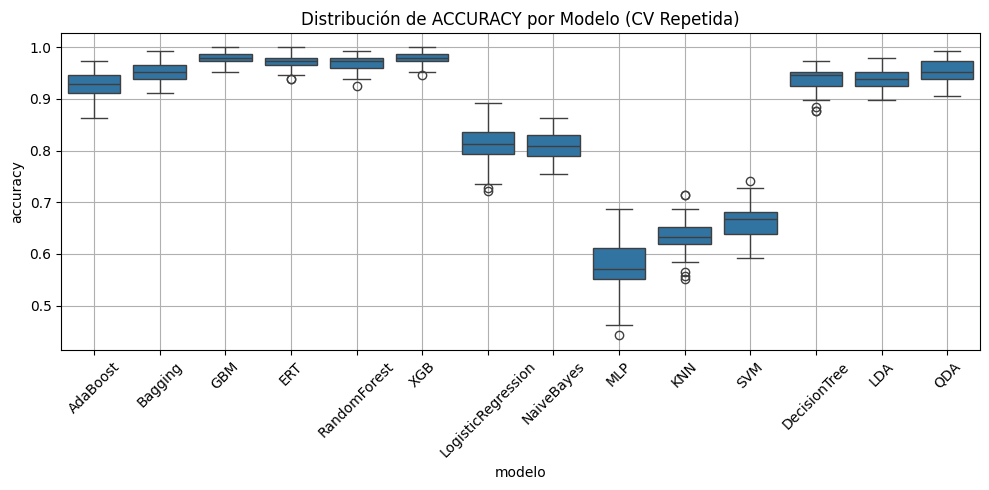

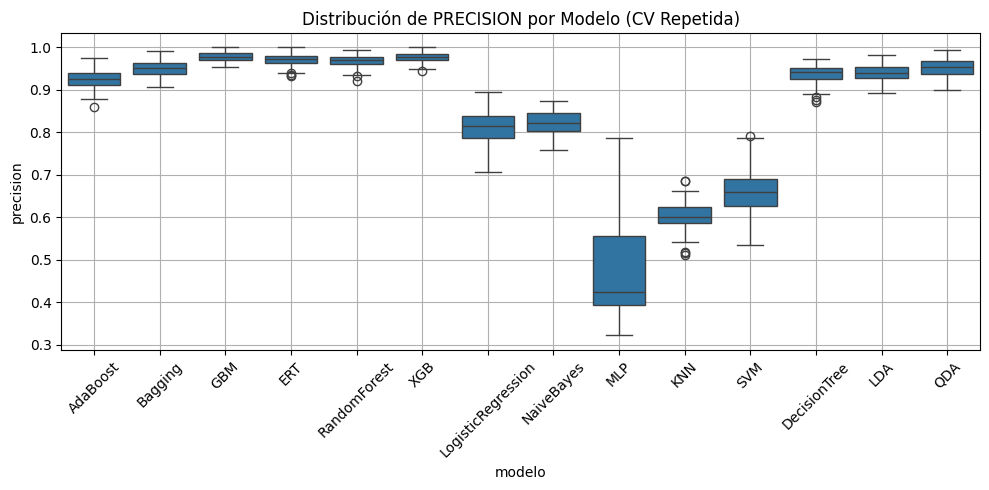

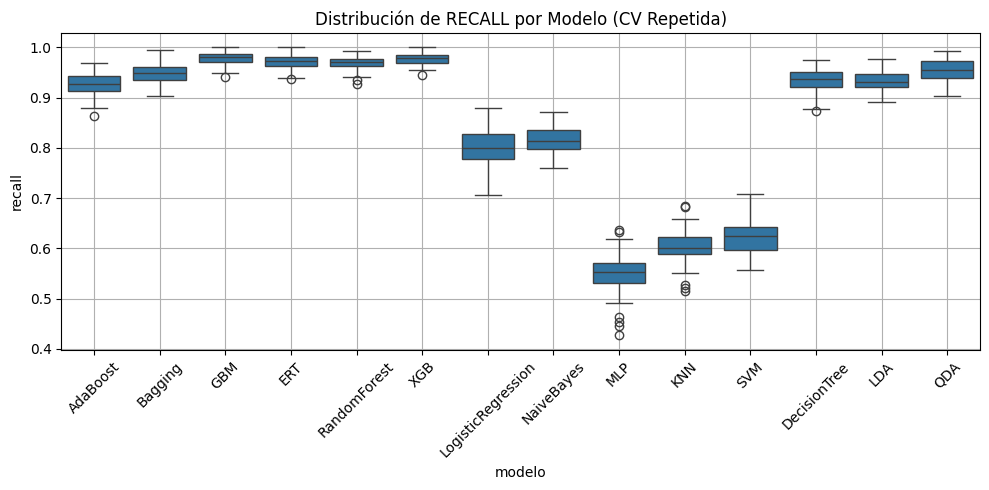

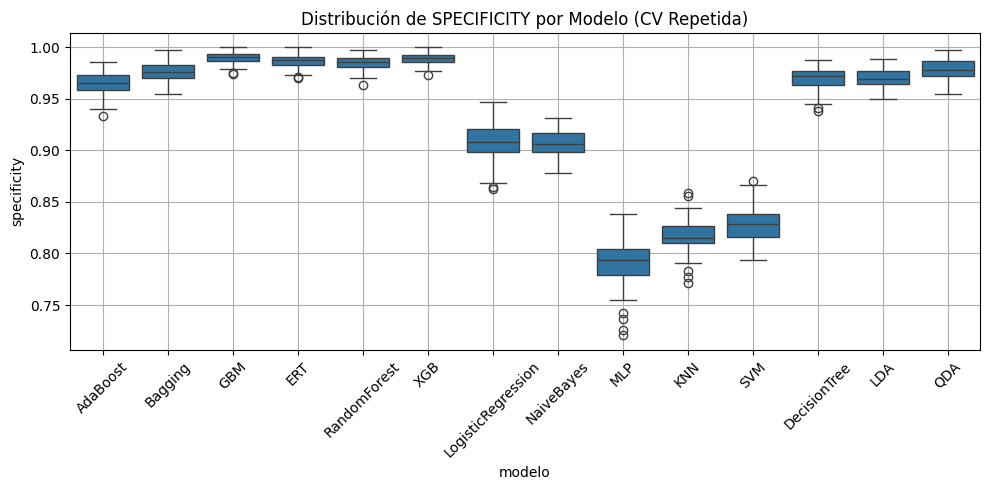

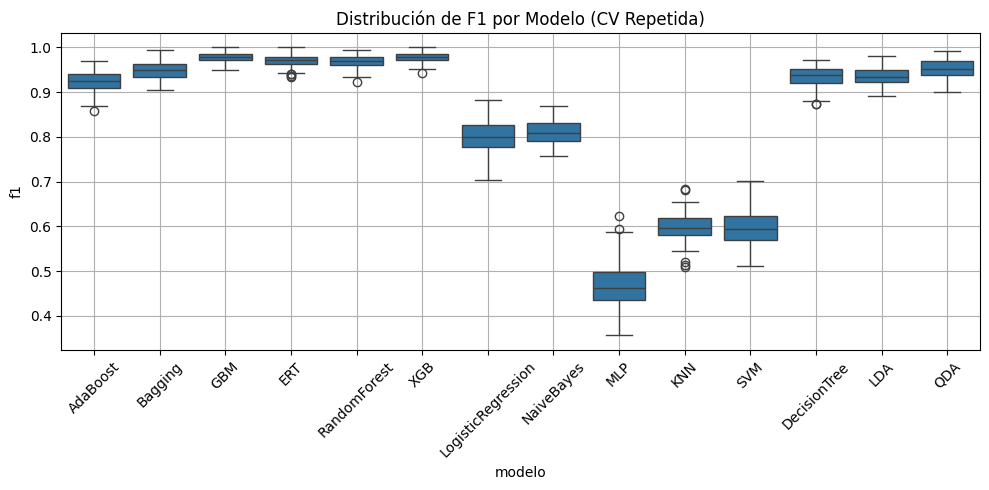

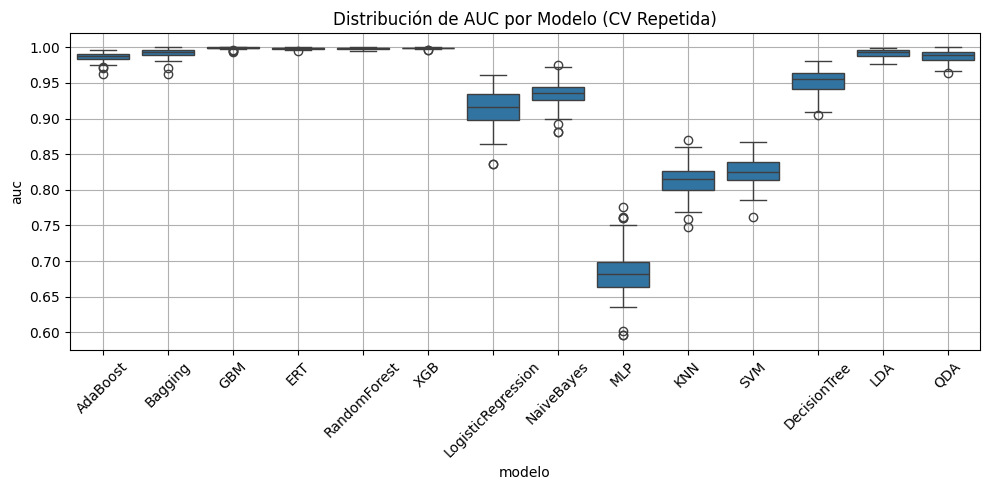

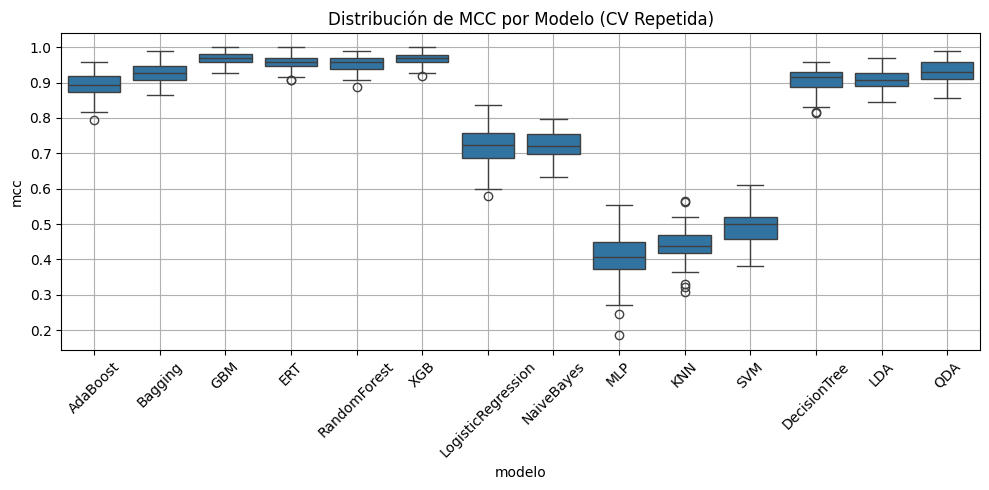

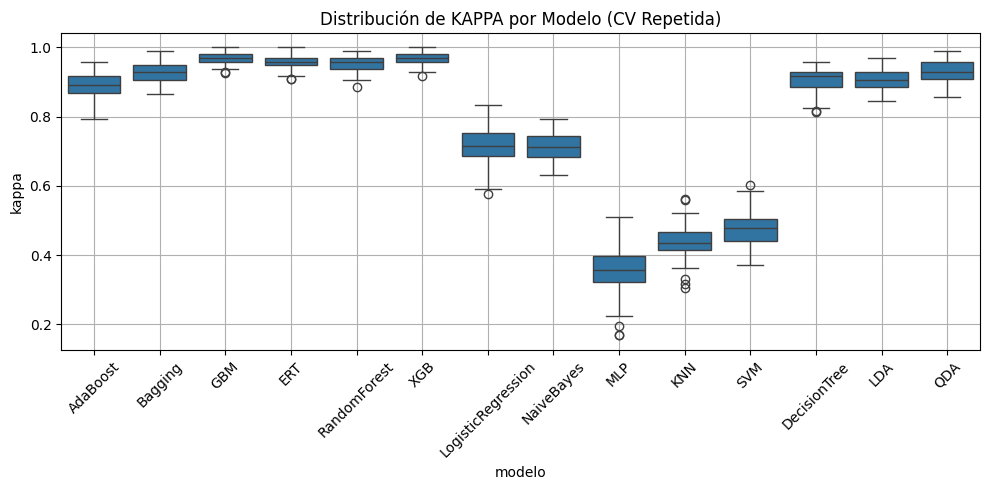

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

metricas_a_graficar = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'auc', 'mcc', 'kappa']

for metrica in metricas_a_graficar:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_resultados_repetidos, x="modelo", y=metrica)
    plt.title(f"Distribución de {metrica.upper()} por Modelo (CV Repetida)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_mo

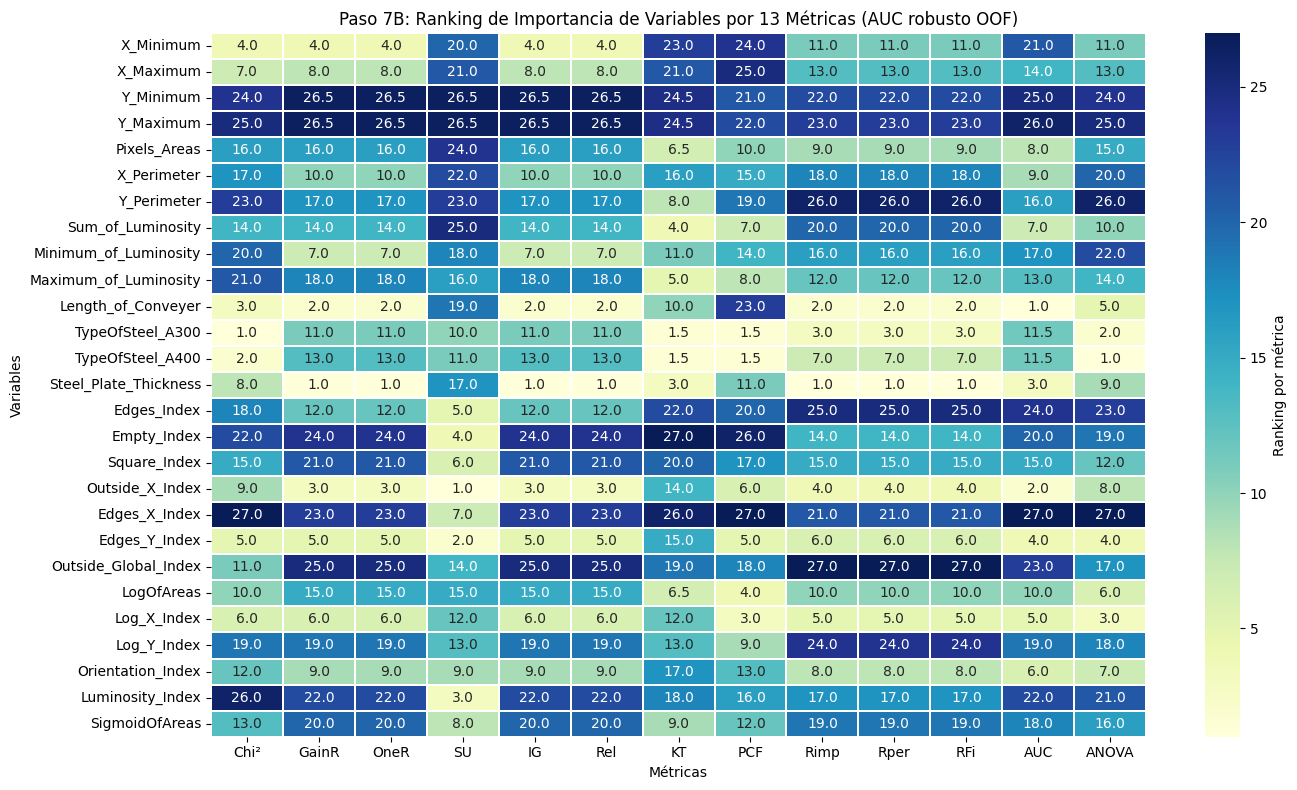

Chi²  GainR  OneR    SU    IG   Rel    KT   PCF  Rimp  \
Steel_Plate_Thickness   8.0    1.0   1.0  17.0   1.0   1.0   3.0  11.0   1.0   
Outside_X_Index         9.0    3.0   3.0   1.0   3.0   3.0  14.0   6.0   4.0   
Edges_Y_Index           5.0    5.0   5.0   2.0   5.0   5.0  15.0   5.0   6.0   
Length_of_Conveyer      3.0    2.0   2.0  19.0   2.0   2.0  10.0  23.0   2.0   
Log_X_Index             6.0    6.0   6.0  12.0   6.0   6.0  12.0   3.0   5.0   
TypeOfSteel_A300        1.0   11.0  11.0  10.0  11.0  11.0   1.5   1.5   3.0   
TypeOfSteel_A400        2.0   13.0  13.0  11.0  13.0  13.0   1.5   1.5   7.0   
Orientation_Index      12.0    9.0   9.0   9.0   9.0   9.0  17.0  13.0   8.0   
LogOfAreas             10.0   15.0  15.0  15.0  15.0  15.0   6.5   4.0  10.0   
X_Minimum               4.0    4.0   4.0  20.0   4.0   4.0  23.0  24.0  11.0   
Pixels_Areas           16.0   16.0  16.0  24.0  16.0  16.0   6.5  10.0   9.0   
X_Maximum               7.0    8.0   8.0  21.0   8.0   8.0  21.0  25.0  13.0   
Minimum_of_Luminosity  20.0    7.0   7.0  18.0   7.0   7.0  11.0  14.0  16.0   
Sum_of_Luminosity      14.0   14.0  14.0  25.0  14.0  14.0   4.0   7.0  20.0   
Maximum_of_Luminosity  21.0   18.0  18.0  16.0  18.0  18.0   5.0   8.0  12.0   
X_Perimeter            17.0   10.0  10.0  22.0  10.0  10.0  16.0  15.0  18.0   
SigmoidOfAreas         13.0   20.0  20.0   8.0  20.0  20.0   9.0  12.0  19.0   
Square_Index           15.0   21.0  21.0   6.0  21.0  21.0  20.0  17.0  15.0   
Edges_Index            18.0   12.0  12.0   5.0  12.0  12.0  22.0  20.0  25.0   
Log_Y_Index            19.0   19.0  19.0  13.0  19.0  19.0  13.0   9.0  24.0   
Luminosity_Index       26.0   22.0  22.0   3.0  22.0  22.0  18.0  16.0  17.0   
Empty_Index            22.0   24.0  24.0   4.0  24.0  24.0  27.0  26.0  14.0   
Y_Perimeter            23.0   17.0  17.0  23.0  17.0  17.0   8.0  19.0  26.0   
Outside_Global_Index   11.0   25.0  25.0  14.0  25.0  25.0  19.0  18.0  27.0   
Edges_X_Index          27.0   23.0  23.0   7.0  23.0  23.0  26.0  27.0  21.0   
Y_Minimum              24.0   26.5  26.5  26.5  26.5  26.5  24.5  21.0  22.0   
Y_Maximum              25.0   26.5  26.5  26.5  26.5  26.5  24.5  22.0  23.0   

                       Rper   RFi   AUC  ANOVA       Mean  Rank  
Steel_Plate_Thickness   1.0   1.0   3.0    9.0   4.461538   1.0  
Outside_X_Index         4.0   4.0   2.0    8.0   4.923077   2.0  
Edges_Y_Index           6.0   6.0   4.0    4.0   5.615385   3.0  
Length_of_Conveyer      2.0   2.0   1.0    5.0   5.769231   4.0  
Log_X_Index             5.0   5.0   5.0    3.0   6.153846   5.0  
TypeOfSteel_A300        3.0   3.0  11.5    2.0   6.192308   6.0  
TypeOfSteel_A400        7.0   7.0  11.5    1.0   7.807692   7.0  
Orientation_Index       8.0   8.0   6.0    7.0   9.538462   8.0  
LogOfAreas             10.0  10.0  10.0    6.0  10.884615   9.0  
X_Minimum              11.0  11.0  21.0   11.0  11.692308  10.0  
Pixels_Areas            9.0   9.0   8.0   15.0  13.115385  11.0  
X_Maximum              13.0  13.0  14.0   13.0  13.230769  12.0  
Minimum_of_Luminosity  16.0  16.0  17.0   22.0  13.692308  13.0  
Sum_of_Luminosity      20.0  20.0   7.0   10.0  14.076923  14.0  
Maximum_of_Luminosity  12.0  12.0  13.0   14.0  14.230769  15.0  
X_Perimeter            18.0  18.0   9.0   20.0  14.846154  16.0  
SigmoidOfAreas         19.0  19.0  18.0   16.0  16.384615  17.0  
Square_Index           15.0  15.0  15.0   12.0  16.461538  18.0  
Edges_Index            25.0  25.0  24.0   23.0  18.076923  19.0  
Log_Y_Index            24.0  24.0  19.0   18.0  18.384615  20.0  
Luminosity_Index       17.0  17.0  22.0   21.0  18.846154  21.0  
Empty_Index            14.0  14.0  20.0   19.0  19.692308  22.0  
Y_Perimeter            26.0  26.0  16.0   26.0  20.076923  23.0  
Outside_Global_Index   27.0  27.0  23.0   17.0  21.769231  24.0  
Edges_X_Index          21.0  21.0  27.0   27.0  22.769231  25.0  
Y_Minimum              22.0  22.0  25.0   24.0  24.384615  26.0  


In [10]:
# ===============================================================
# PASO 7 (FIX DEFINITIVO): Importancia de variables con AUC robusto
# - Maneja NaN/Inf con imputación
# - Evita columnas constantes
# - AUC por variable con probas out-of-fold (StratifiedKFold)
# - Alinea clases por pliegue (evita mismatches)
# ===============================================================

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import kendalltau, pointbiserialr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 0) Preprocesamiento base
# -------------------------------
df_importancia = df.copy()  # dataset de trabajo con 'target'
assert 'target' in df_importancia.columns, "No encuentro la columna 'target' en df."

le_imp = LabelEncoder()
df_importancia['target'] = le_imp.fit_transform(df_importancia['target'])

# (solo numéricas para las métricas)
X_imp = df_importancia.drop('target', axis=1).select_dtypes(include=[np.number]).copy()
y_imp = df_importancia['target'].values

# Sanitizar: Inf -> NaN, imputación mediana
X_imp = X_imp.replace([np.inf, -np.inf], np.nan)

# Imputador para todos los cálculos estadísticos que requieren X limpio
imputer_all = SimpleImputer(strategy='median')
X_imp_clean = pd.DataFrame(imputer_all.fit_transform(X_imp), columns=X_imp.columns, index=X_imp.index)

# Escalar SOLO para chi2 (requerido)
scaler = MinMaxScaler()
X_imp_scaled = pd.DataFrame(scaler.fit_transform(X_imp_clean), columns=X_imp.columns, index=X_imp.index)

# -------------------------------
# 1) Métricas estadísticas básicas
# -------------------------------
chi2_vals, _ = chi2(X_imp_scaled, y_imp)
mi_vals = mutual_info_classif(X_imp_clean, y_imp, random_state=42)
anova_vals, _ = f_classif(X_imp_clean, y_imp)

# -------------------------------
# 2) Random Forest Importance
# -------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp_clean, y_imp)
rfi_vals = rf.feature_importances_

# -------------------------------
# 3) AUC por variable (ROBUSTO OOF)
# -------------------------------
def feature_auc_oof(X_df, y, n_splits=5, random_state=42):
    """
    Calcula AUC macro (OvR) por característica usando predicciones out-of-fold.
    Maneja NaN/Inf, columnas constantes y pliegues con clases faltantes.
    """
    cols = X_df.columns.tolist()
    classes = np.unique(y)
    y_bin = label_binarize(y, classes=classes)
    n_classes = y_bin.shape[1]

    auc_vals = []
    issues = []   # para diagnóstico

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for col in cols:
        Xi = X_df[[col]].values  # (n,1)

        # columna constante -> AUC indefinido
        if np.nanstd(Xi) == 0:
            auc_vals.append(np.nan)
            issues.append((col, "columna constante"))
            continue

        # Imputación + escala + LR (un pipeline por si aparecen NaN)
        pipe = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("std", StandardScaler()),
            ("lr", LogisticRegression(max_iter=1000, multi_class="auto"))
        ])

        # Contenedor OOF
        proba_oof = np.zeros((len(y), n_classes), dtype=float)
        filled = np.zeros(len(y), dtype=bool)

        for tr, te in skf.split(Xi, y):
            # si en el pliegue hay 1 sola clase, saltamos (no entrenable)
            if len(np.unique(y[tr])) < 2:
                continue

            pipe.fit(Xi[tr], y[tr])
            proba = pipe.predict_proba(Xi[te])  # (len(te), k_pliegue)

            # Alinear columnas de proba con 'classes'
            model_classes = pipe.named_steps["lr"].classes_
            for j, cls in enumerate(model_classes):
                idx = np.where(classes == cls)[0][0]
                proba_oof[te, idx] = proba[:, j]

            filled[te] = True

        # si ningún fold cargó predicciones:
        if not filled.any():
            auc_vals.append(np.nan)
            issues.append((col, "sin predicciones OOF (pliegues con 1 clase)"))
            continue

        # rellenar indices no vistos con prior de clases (suave)
        if not filled.all():
            priors = np.bincount(y, minlength=n_classes) / len(y)
            proba_oof[~filled, :] = priors

        # AUC macro OvR
        try:
            auc = roc_auc_score(y_bin, proba_oof, average="macro", multi_class="ovr")
        except Exception as e:
            auc = np.nan
            issues.append((col, f"roc_auc_score fallo: {e}"))

        auc_vals.append(auc)

    return pd.Series(auc_vals, index=cols), pd.DataFrame(issues, columns=["feature", "motivo"])

auc_series, auc_diag = feature_auc_oof(X_imp, y_imp)

# -------------------------------
# 4) Correlaciones estadísticas adicionales
# -------------------------------
kt_vals = [abs(kendalltau(X_imp_clean[col], y_imp).correlation) for col in X_imp_clean.columns]
pcf_vals = [abs(pointbiserialr(X_imp_clean[col], y_imp)[0]) for col in X_imp_clean.columns]

# -------------------------------
# 5) Métricas aproximadas para completar las 13
# -------------------------------
gainr_vals = mi_vals
oner_vals  = mi_vals
su_vals    = mi_vals / (X_imp_clean.var().values + 1e-6)
rel_vals   = mi_vals
rimp_vals  = rfi_vals
rper_vals  = rfi_vals

# -------------------------------
# 6) DataFrame de importancia
# -------------------------------
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_series.values,
    'ANOVA': anova_vals
}, index=X_imp_clean.columns)

# -------------------------------
# 7) Ranking final
# -------------------------------
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# ===============================================================
# 8️⃣ Visualización del ranking con valores anotados
# ===============================================================
plt.figure(figsize=(14, 8))
sns.heatmap(
    ranking_df.iloc[:, :-2],
    annot=True,         # 🔹 mostrar valores dentro de las celdas
    fmt=".1f",          # 🔹 formato numérico
    linewidths=.3,      # 🔹 líneas divisorias finas
    cmap='YlGnBu',
    cbar_kws={'label': 'Ranking por métrica'}
)
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas (AUC robusto OOF)")
plt.xlabel("Métricas")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# Mostrar ranking ordenado final
ranking_final = ranking_df.sort_values("Rank")
display(ranking_final)

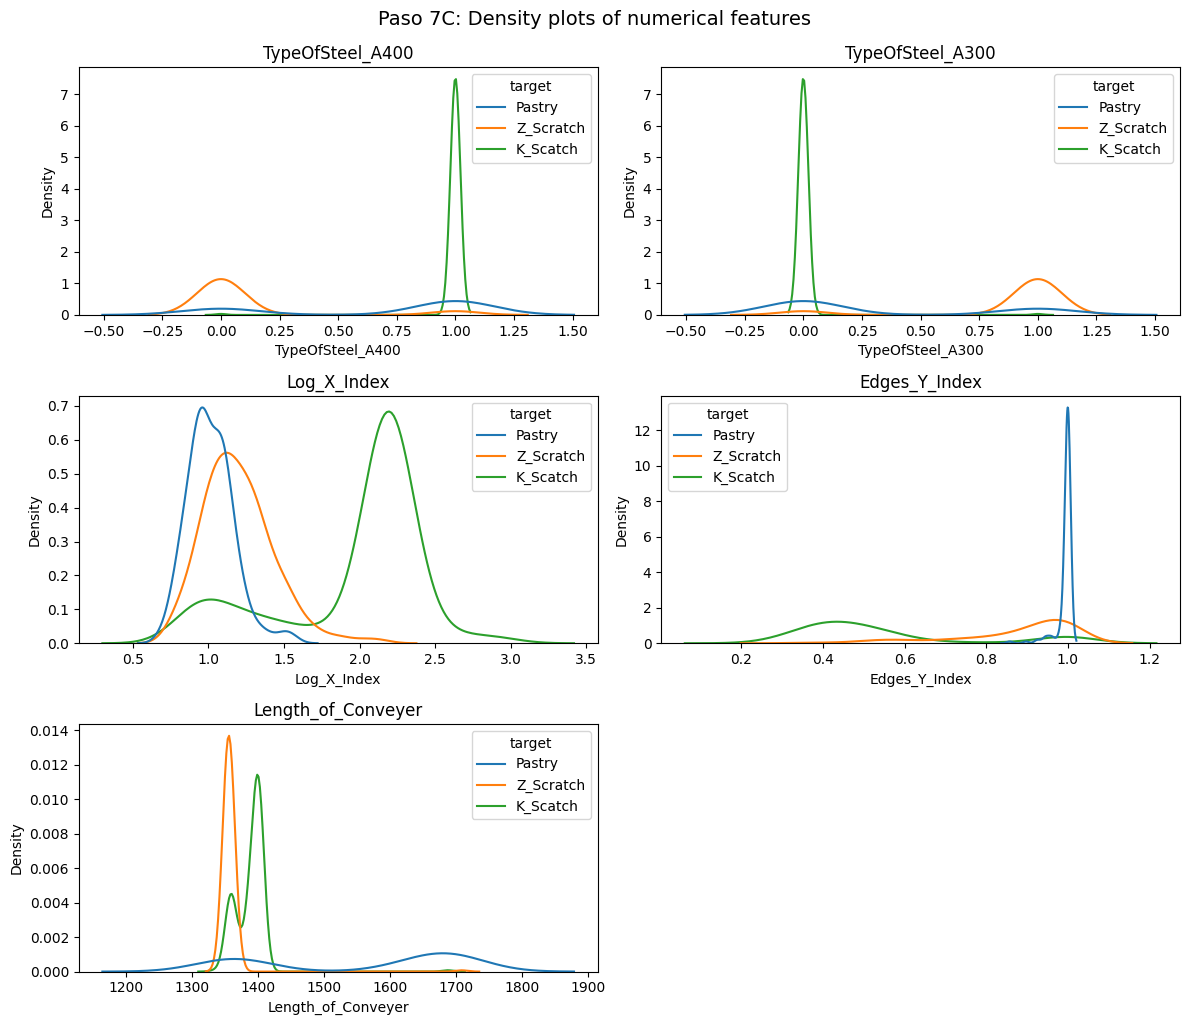

In [11]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase

numerical_features = ['TypeOfSteel_A400', 'TypeOfSteel_A300', 'Log_X_Index', 'Edges_Y_Index', 'Length_of_Conveyer']

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=col, hue='target', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Paso 7C: Density plots of numerical features", fontsize=14, y=1.02)
plt.show()


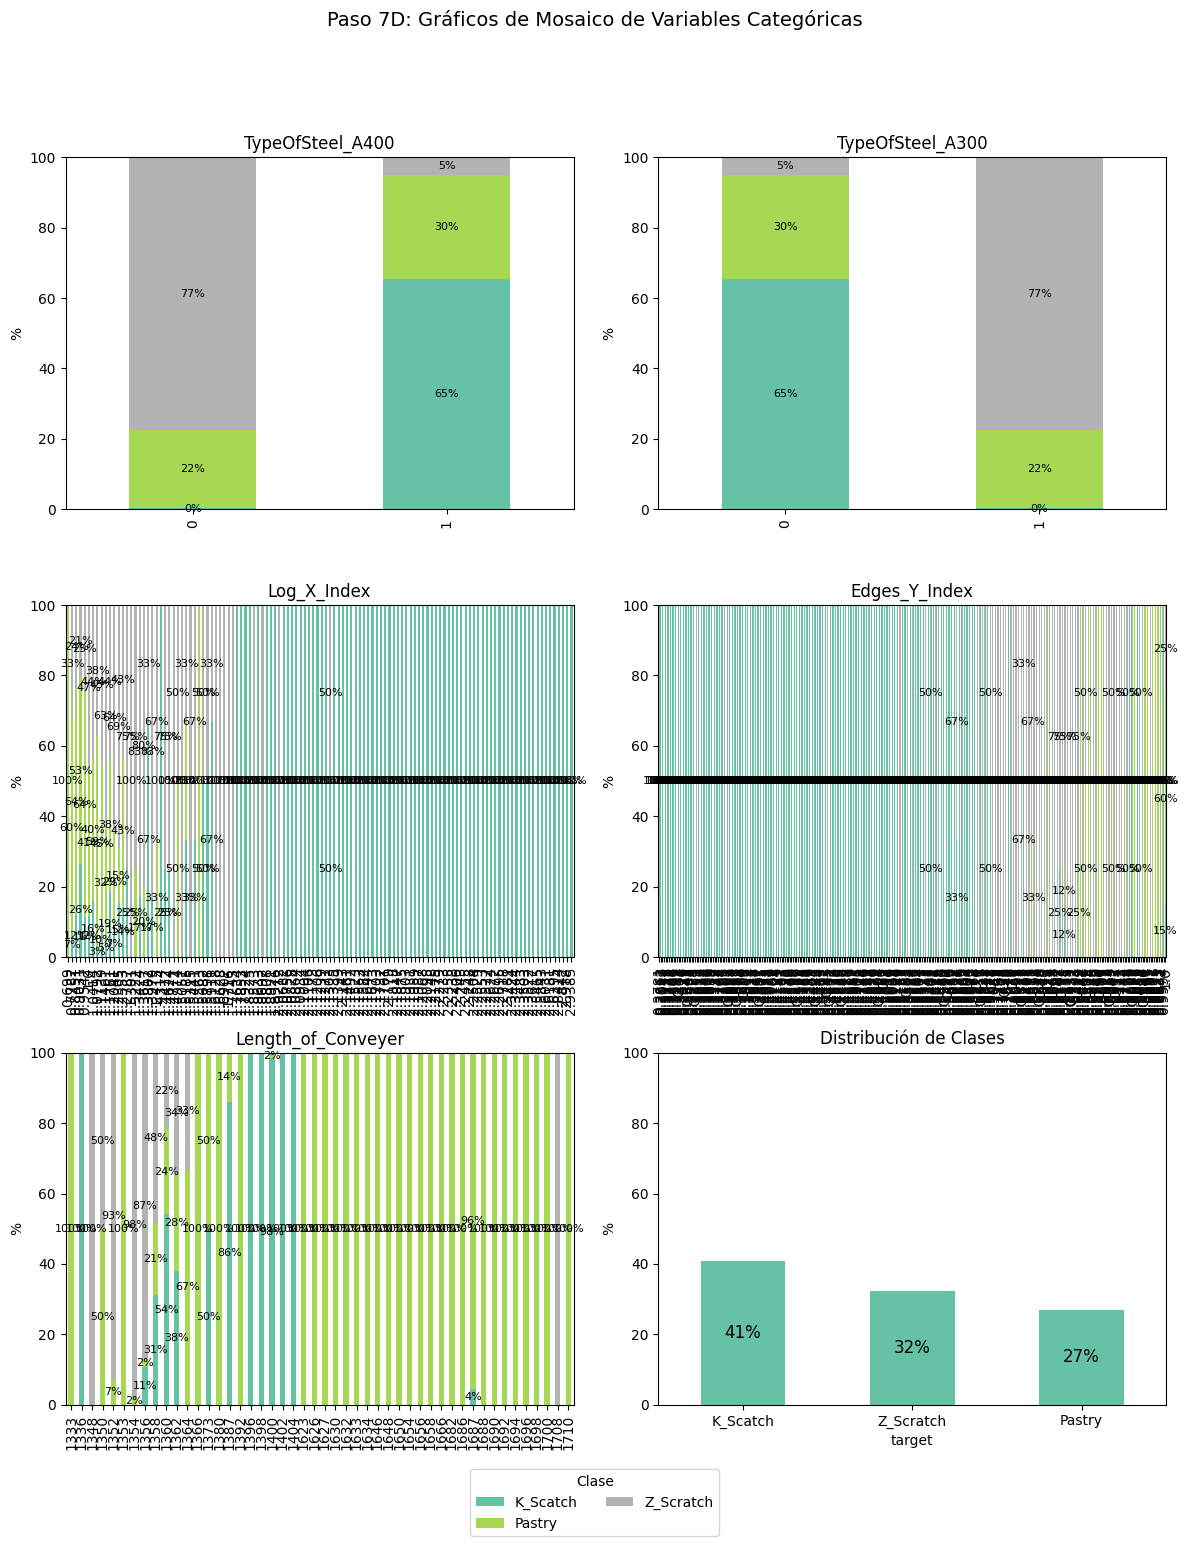

In [12]:
# Paso 7D: Gráficos de mosaico para variables categóricas (adaptado a faults-10.csv)

# Suponiendo que df ya contiene la columna 'target'
# Y que estas son las variables categóricas representativas
categorical_columns_mosaic = ['TypeOfSteel_A400', 'TypeOfSteel_A300', 'Log_X_Index', 'Edges_Y_Index', 'Length_of_Conveyer','target']
df_mosaic = df.copy()

# Asegurar que estén como categóricas
df_mosaic[categorical_columns_mosaic] = df_mosaic[categorical_columns_mosaic].astype('category')

# Graficar
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_columns_mosaic):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(df_mosaic[col], df_mosaic['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='black', fontsize=8)
        ax.set_title(col)
        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
    else:
        class_counts = df_mosaic['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', ax=ax, colormap='Set2')
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='black', fontsize=12)
        ax.set_title("Distribución de Clases")
        ax.set_ylabel('%')
        ax.set_xticklabels(class_counts.index, rotation=0)
        ax.set_ylim(0, 100)

# Quitar ejes vacíos si hay menos subgráficos
for j in range(len(categorical_columns_mosaic), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Clase", loc='lower center', ncol=2)
plt.suptitle('Paso 7D: Gráficos de Mosaico de Variables Categóricas', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


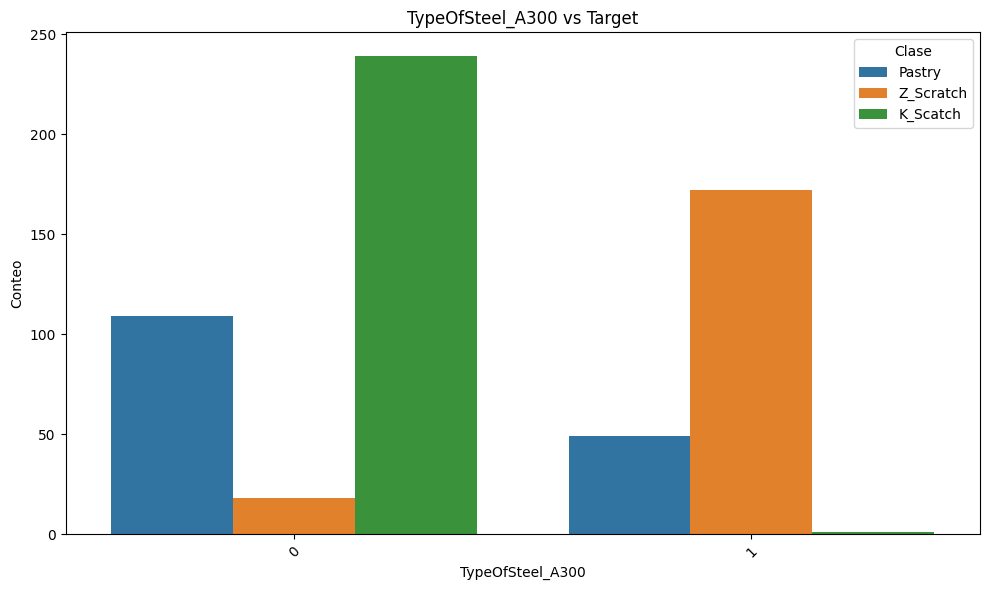

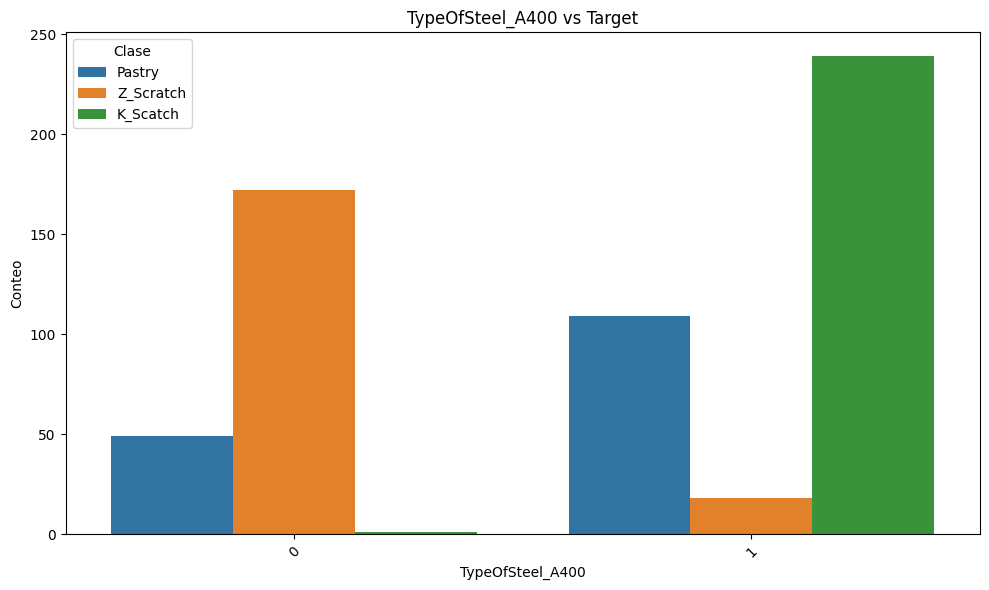

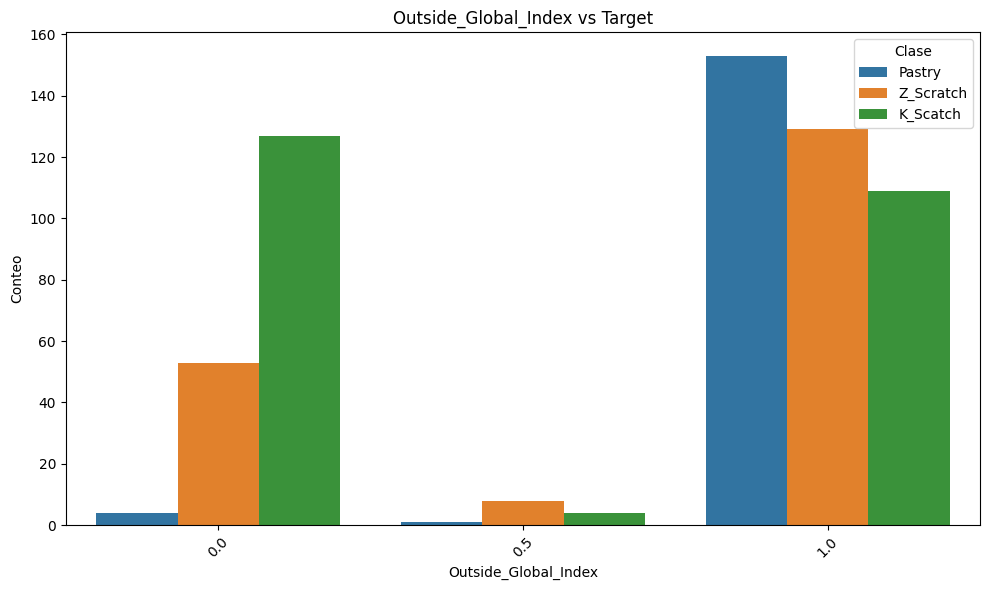

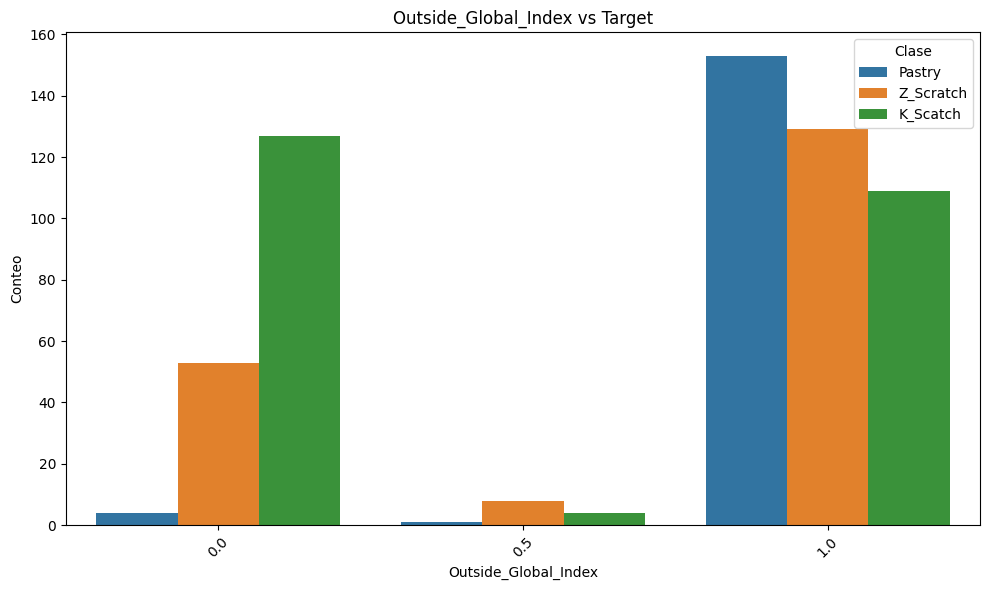

In [13]:
# Paso 8: Gráficos de conteo de variables categóricas vs target
# Convertir target a string
df['target'] = df['target'].astype(str)

# Definir variables categóricas a analizar
categorical_columns = ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index', 'Outside_Global_Index']

# Graficar conteos por clase
for col in categorical_columns:
    if col != 'target':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='target', data=df)
        plt.title(f'{col} vs Target')
        plt.xlabel(col)
        plt.ylabel('Conteo')
        plt.xticks(rotation=45)
        plt.legend(title='Clase')
        plt.tight_layout()
        plt.show()


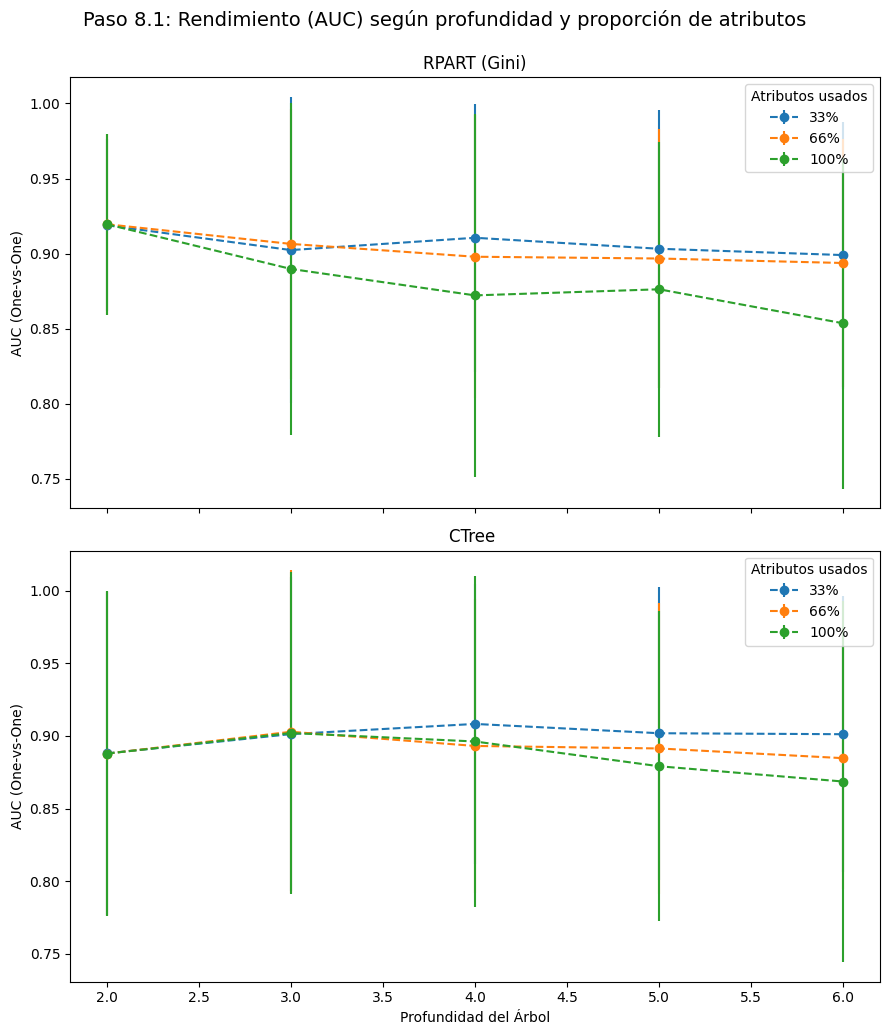

In [14]:
#paso 8.1: rendimiento (AUC) con profundidad y porcentaje de atributos
# Subconjuntos definidos
# Paso 8.1: Rendimiento (AUC multiclase) con diferentes profundidades y proporciones de atributos

# Preparar el dataset
df_encoded = df.copy()
le_auc = LabelEncoder()
df_encoded["target"] = le_auc.fit_transform(df_encoded["target"])

# Subconjuntos de atributos según ranking
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_vars = df_encoded.columns.drop("target").tolist()

attribute_sets = {
    '33%': top_5,
    '66%': top_10,
    '100%': all_vars
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, feature_list in attribute_sets.items():
    X = df_encoded[feature_list].astype('float64')
    y = df_encoded['target']

    for depth in depths:
        # RPART - criterio Gini
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X, y, cv=5, scoring='roc_auc_ovo')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        # CTREE - criterio Entropía
        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X, y, cv=5, scoring='roc_auc_ovo')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

# Convertir resultados a DataFrame
rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

# Gráfico de AUC por profundidad
fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART (Gini)")
axes[0].set_ylabel("AUC (One-vs-One)")
axes[0].legend(title="Atributos usados")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("CTree ")
axes[1].set_xlabel("Profundidad del Árbol")
axes[1].set_ylabel("AUC (One-vs-One)")
axes[1].legend(title="Atributos usados")

plt.tight_layout()
plt.suptitle("Paso 8.1: Rendimiento (AUC) según profundidad y proporción de atributos", fontsize=14, y=1.03)
plt.show()


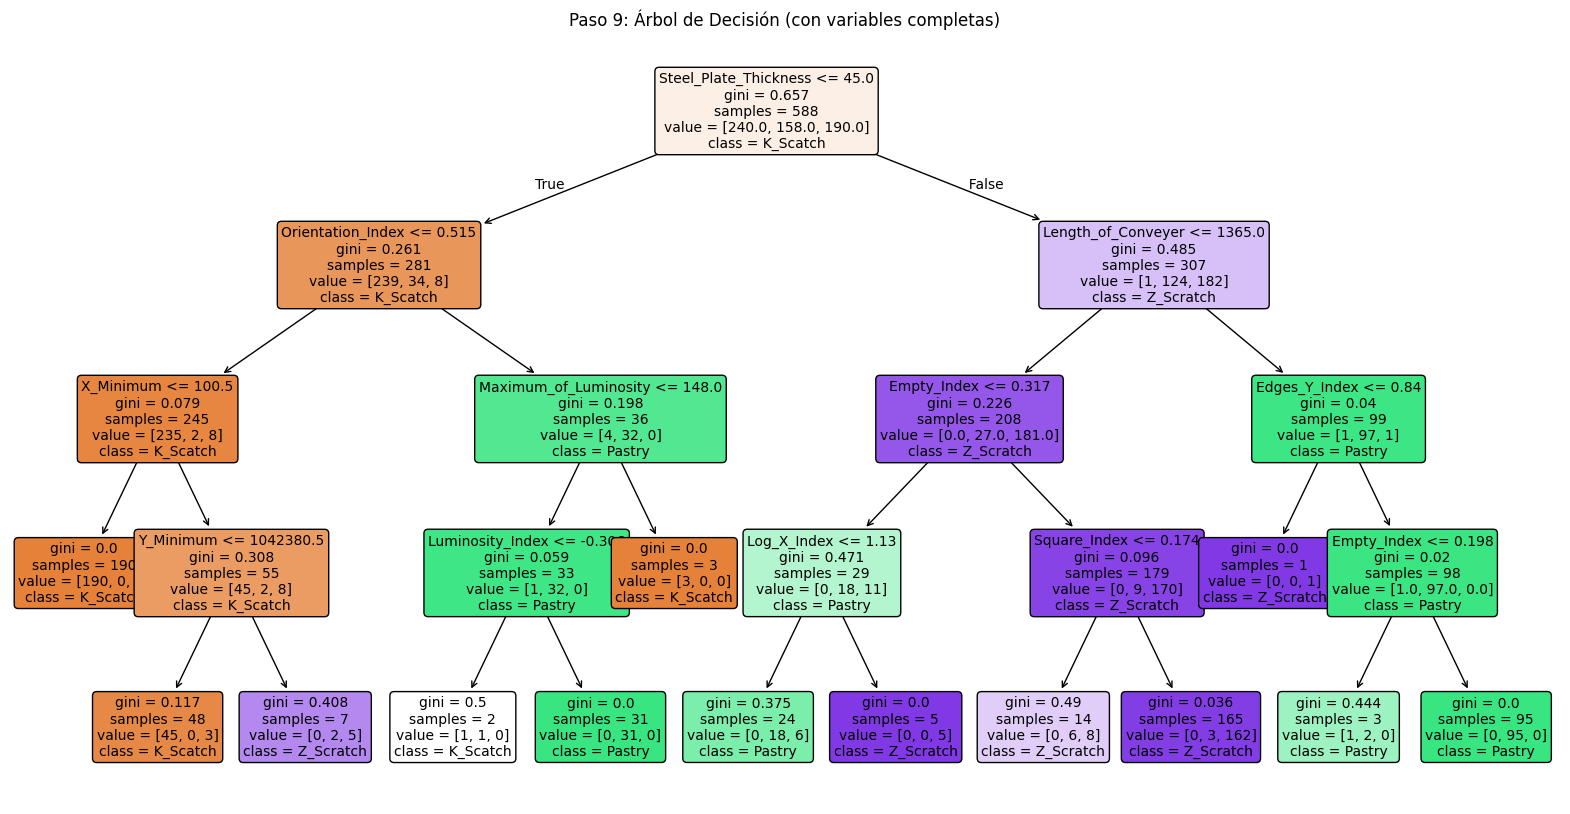

In [15]:
# Paso 9: Árbol de decisión con todas las variables

# Asegurarnos de tener variables codificadas
X_tree = df_encoded.drop(columns=["target"])
y_tree = df_encoded["target"]

# Entrenar árbol completo
dt = DecisionTreeClassifier(max_depth=4, random_state=42)  # puedes ajustar max_depth si deseas
dt.fit(X_tree, y_tree)

# Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    filled=True,
    feature_names=list(X_tree.columns),
    class_names=le_auc.classes_,  # etiquetas originales
    rounded=True,
    fontsize=10
)
plt.title("Paso 9: Árbol de Decisión (con variables completas)")
plt.show()

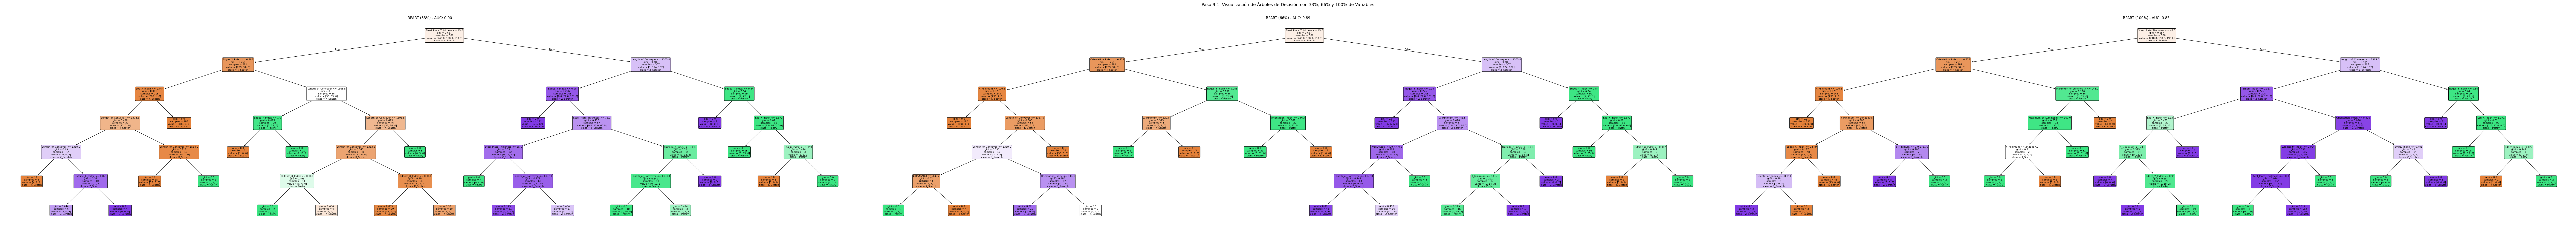

In [ ]:
# Paso 9.1: Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)

# Asegurarse de tener datos codificados
X_all = df_encoded.drop(columns=["target"])
y_all = df_encoded["target"]

# Crear subconjuntos según ranking
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

attribute_sets = {
    '33%': top_5,
    '66%': top_10,
    '100%': all_features
}

fig, axes = plt.subplots(1, 3, figsize=(120, 8))
rpart_auc_scores = {}

for ax, (name, features) in zip(axes, attribute_sets.items()):
    X = df_encoded[features].astype('float64')
    y = df_encoded['target']

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X, y)

    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovo').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X.columns),
        class_names=le_auc.classes_,
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.suptitle("Paso 9.1: Visualización de Árboles de Decisión con 33%, 66% y 100% de Variables", fontsize=14, y=1.05)
plt.show()



In [17]:
from sklearn.tree import export_graphviz
import graphviz

# Paso 9.2: Exportación de árbol con 33% de variables usando Graphviz

# Usar top 5 variables del ranking como 33%
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
X_33 = df_encoded[top_5].astype('float64')
y_33 = df_encoded['target']

# Entrenar modelo
model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

# Exportar a formato .dot y visualizar
dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=X_33.columns,
    class_names=le_auc.classes_,
    filled=True,
    rounded=True,
    special_characters=True
)

graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)  # Exportar como PNG
graph_33.view()  # Abrir en visor por defecto

'tree_33.pdf'

In [18]:
# 66%
# Paso 9.3: Exportación de árbol con 66% de variables usando Graphviz

# Usar top 10 variables del ranking como 66%
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
X_66 = df_encoded[top_10].astype('float64')
y_66 = df_encoded['target']

# Entrenar modelo
model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)

# Exportar a formato .dot y generar imagen
dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=X_66.columns,
    class_names=le_auc.classes_,  # clases originales del LabelEncoder
    filled=True,
    rounded=True,
    special_characters=True
)

graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)  # Exportar como PNG
graph_66.view()  # Mostrar en visor

'tree_66.pdf'

Evaluando AdaBoost con subconjunto 33%
Evaluando Bagging con subconjunto 33%
Evaluando GBM con subconjunto 33%
Evaluando ERT con subconjunto 33%
Evaluando RandomForest con subconjunto 33%
Evaluando XGB con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 33%
Evaluando MLP con subconjunto 33%
Evaluando KNN con subconjunto 33%
Evaluando SVM con subconjunto 33%
Evaluando DecisionTree con subconjunto 33%
Evaluando LDA con subconjunto 33%
Evaluando QDA con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of param

Evaluando AdaBoost con subconjunto 66%
Evaluando Bagging con subconjunto 66%
Evaluando GBM con subconjunto 66%
Evaluando ERT con subconjunto 66%
Evaluando RandomForest con subconjunto 66%
Evaluando XGB con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:03:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:03:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:03:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:03:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 66%
Evaluando MLP con subconjunto 66%
Evaluando KNN con subconjunto 66%
Evaluando SVM con subconjunto 66%
Evaluando DecisionTree con subconjunto 66%
Evaluando LDA con subconjunto 66%
Evaluando QDA con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of param

Evaluando AdaBoost con subconjunto 100%
Evaluando Bagging con subconjunto 100%
Evaluando GBM con subconjunto 100%
Evaluando ERT con subconjunto 100%
Evaluando RandomForest con subconjunto 100%
Evaluando XGB con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Evaluando NaiveBayes con subconjunto 100%
Evaluando MLP con subconjunto 100%
Evaluando KNN con subconjunto 100%
Evaluando SVM con subconjunto 100%
Evaluando DecisionTree con subconjunto 100%
Evaluando LDA con subconjunto 100%
Evaluando QDA con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of param

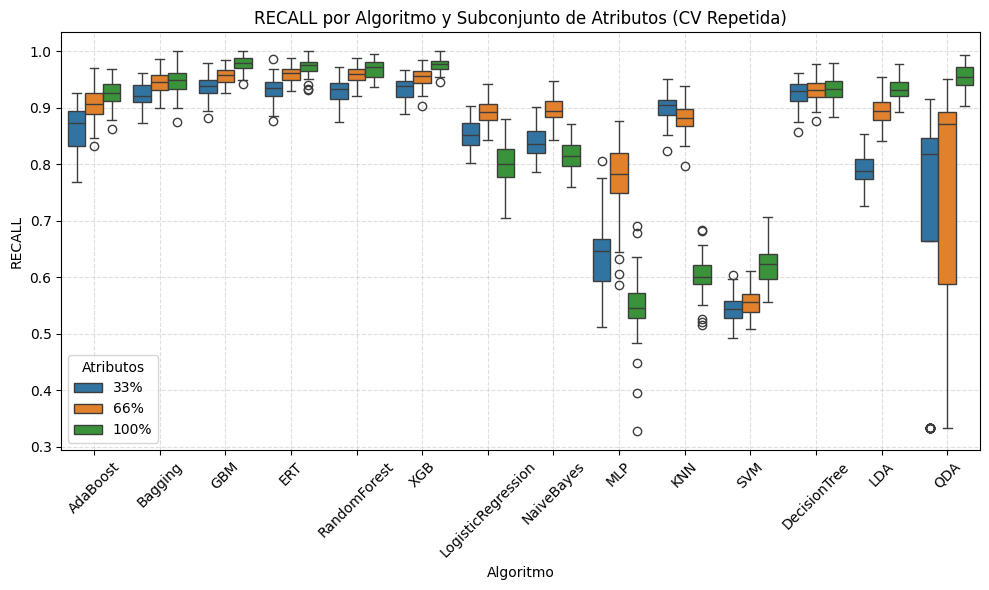

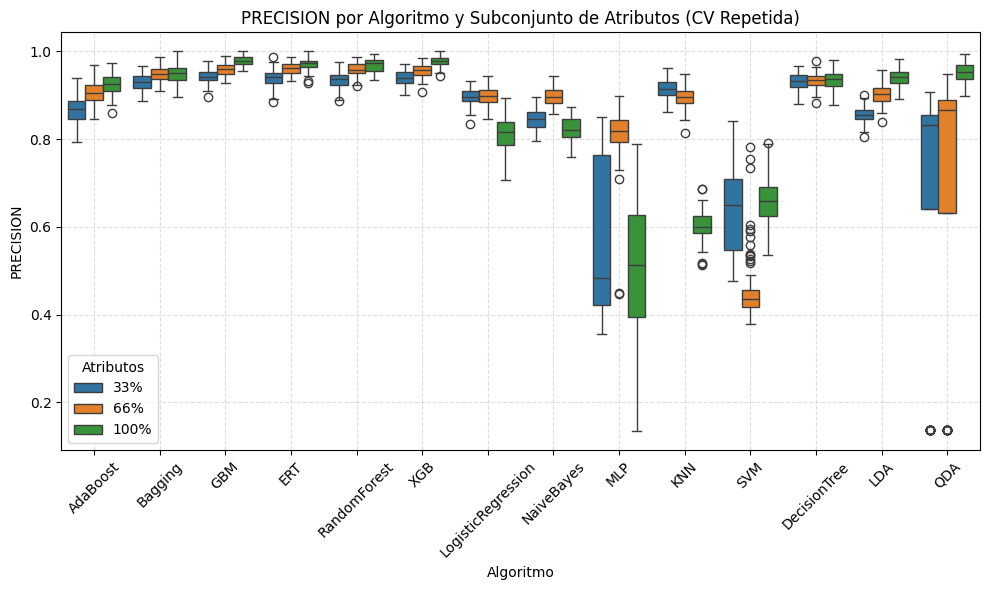

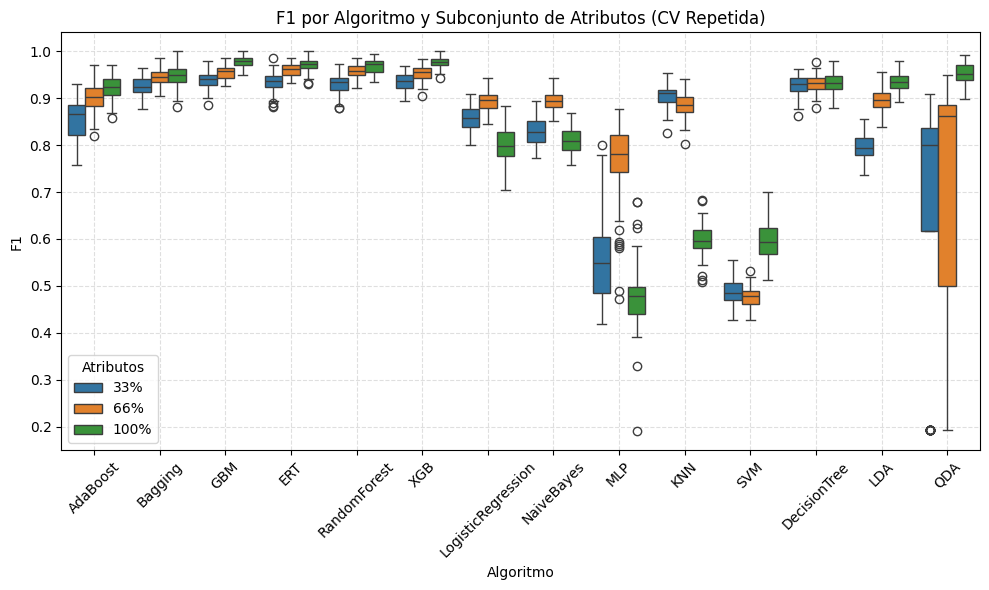

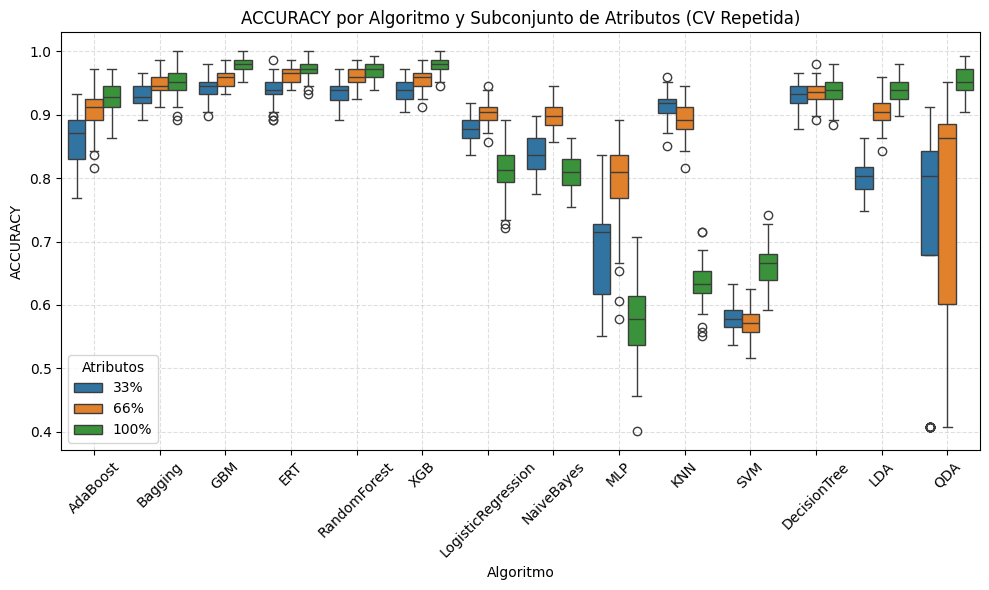

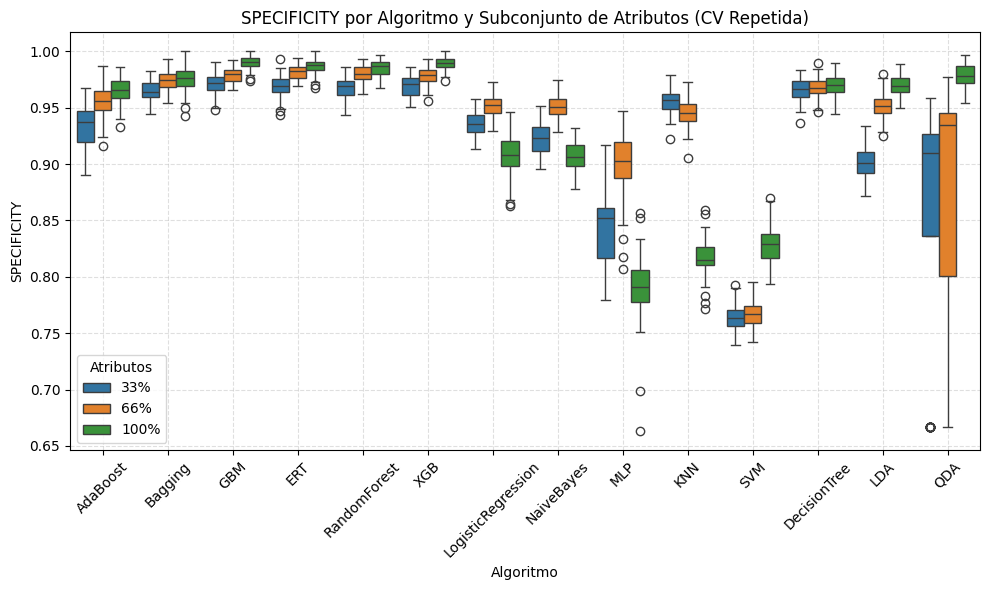

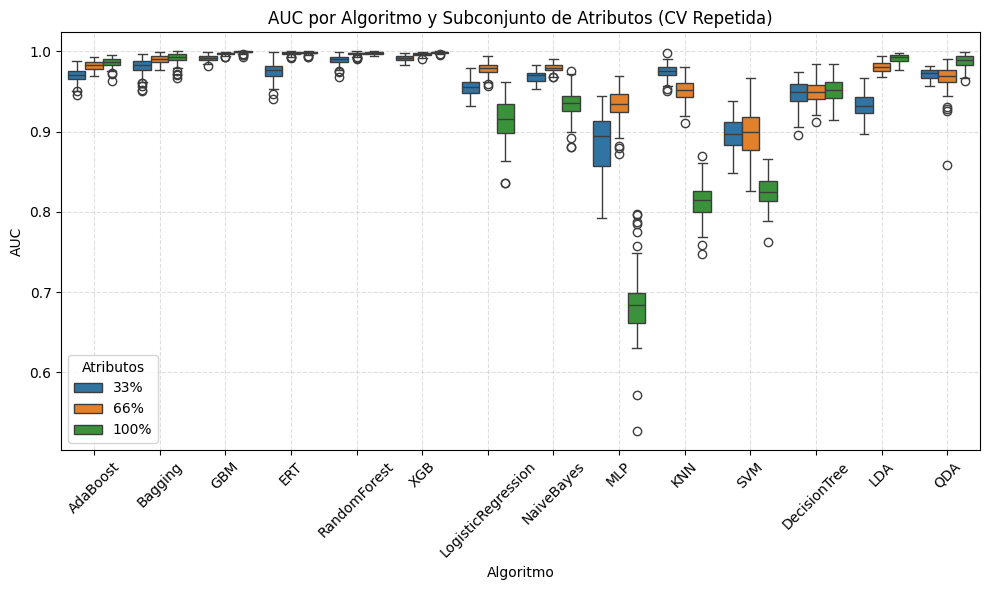

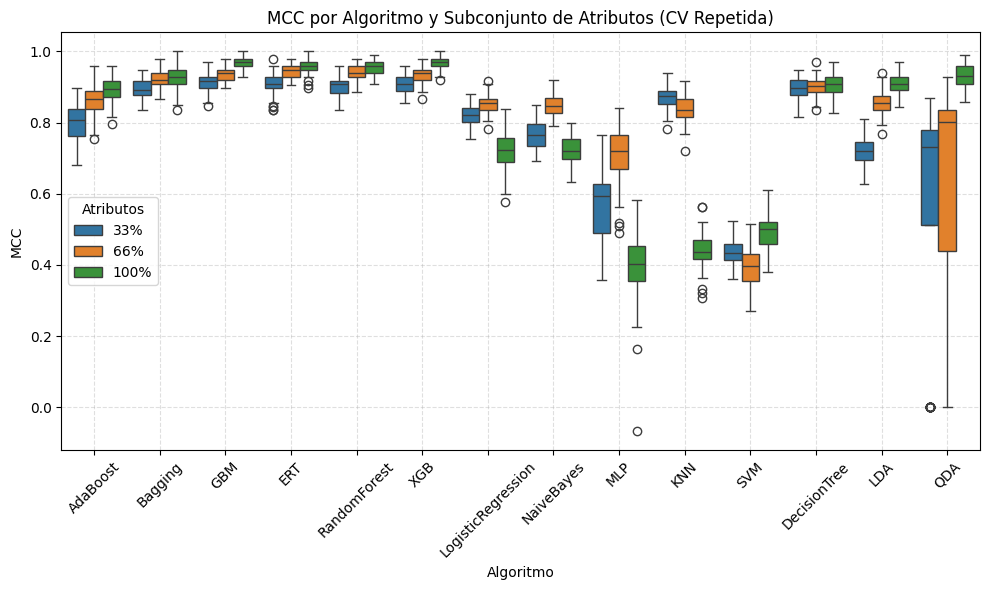

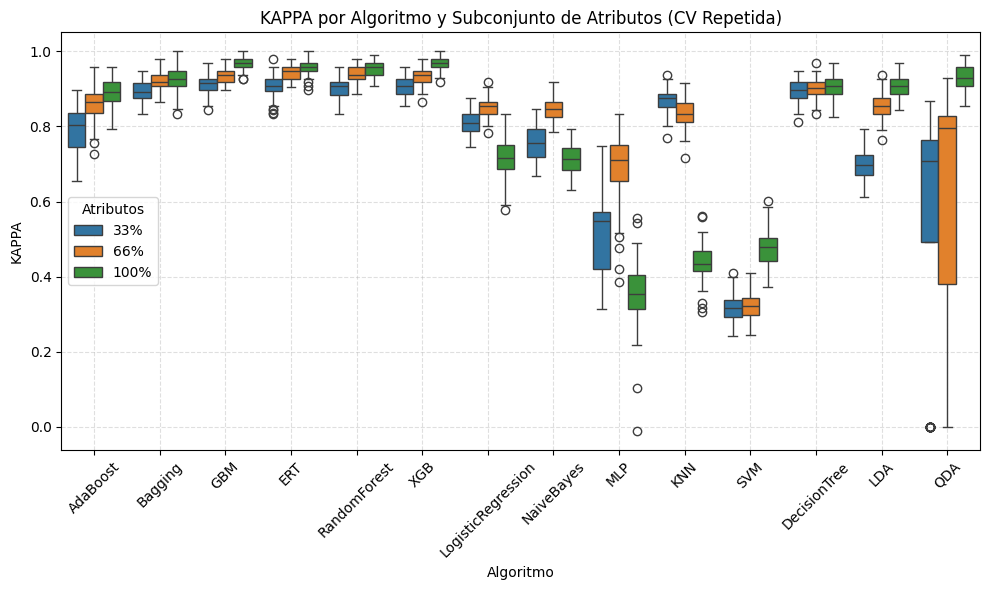

In [19]:
# Paso 10: Evaluación de modelos con 33%, 66% y 100% de variables

# Definir subconjuntos basados en el ranking
top_5 = ranking_df.sort_values("Rank").head(5).index.tolist()
top_10 = ranking_df.sort_values("Rank").head(10).index.tolist()
all_features = df_encoded.columns.drop("target").tolist()

datasets = {
    '33%': df_encoded[top_5 + ['target']],
    '66%': df_encoded[top_10 + ['target']],
    '100%': df_encoded[all_features + ['target']]
}

results_all = []


for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1).astype('float64')
    y = dataset['target']

    # Codificar etiquetas como enteros para compatibilidad con todos los modelos
    #le_temp = LabelEncoder()
    #y_encoded = pd.Series(le_temp.fit_transform(y))
    y_encoded = LabelEncoder().fit_transform(y)

    for model_label, model in models.items():
        print(f"Evaluando {model_label} con subconjunto {name}")
        df_metrics = repeated_cv_metrics(model, X, y_encoded, n_repeats=20, n_splits=4)
        df_metrics['Algorithm'] = model_label
        #df_metrics['Atributos'] = name
        df_metrics['attr'] = name
        results_all.append(df_metrics)

# Consolidar resultados
df_results_all = pd.concat(results_all, ignore_index=True)


for metric in ['recall', 'precision', 'f1', 'accuracy', 'specificity', 'auc', 'mcc', 'kappa']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Algorithm', y=metric, hue='attr', data=df_results_all)
    plt.title(f'{metric.upper()} por Algoritmo y Subconjunto de Atributos (CV Repetida)')
    plt.xlabel('Algoritmo')
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45)
    plt.legend(title='Atributos')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


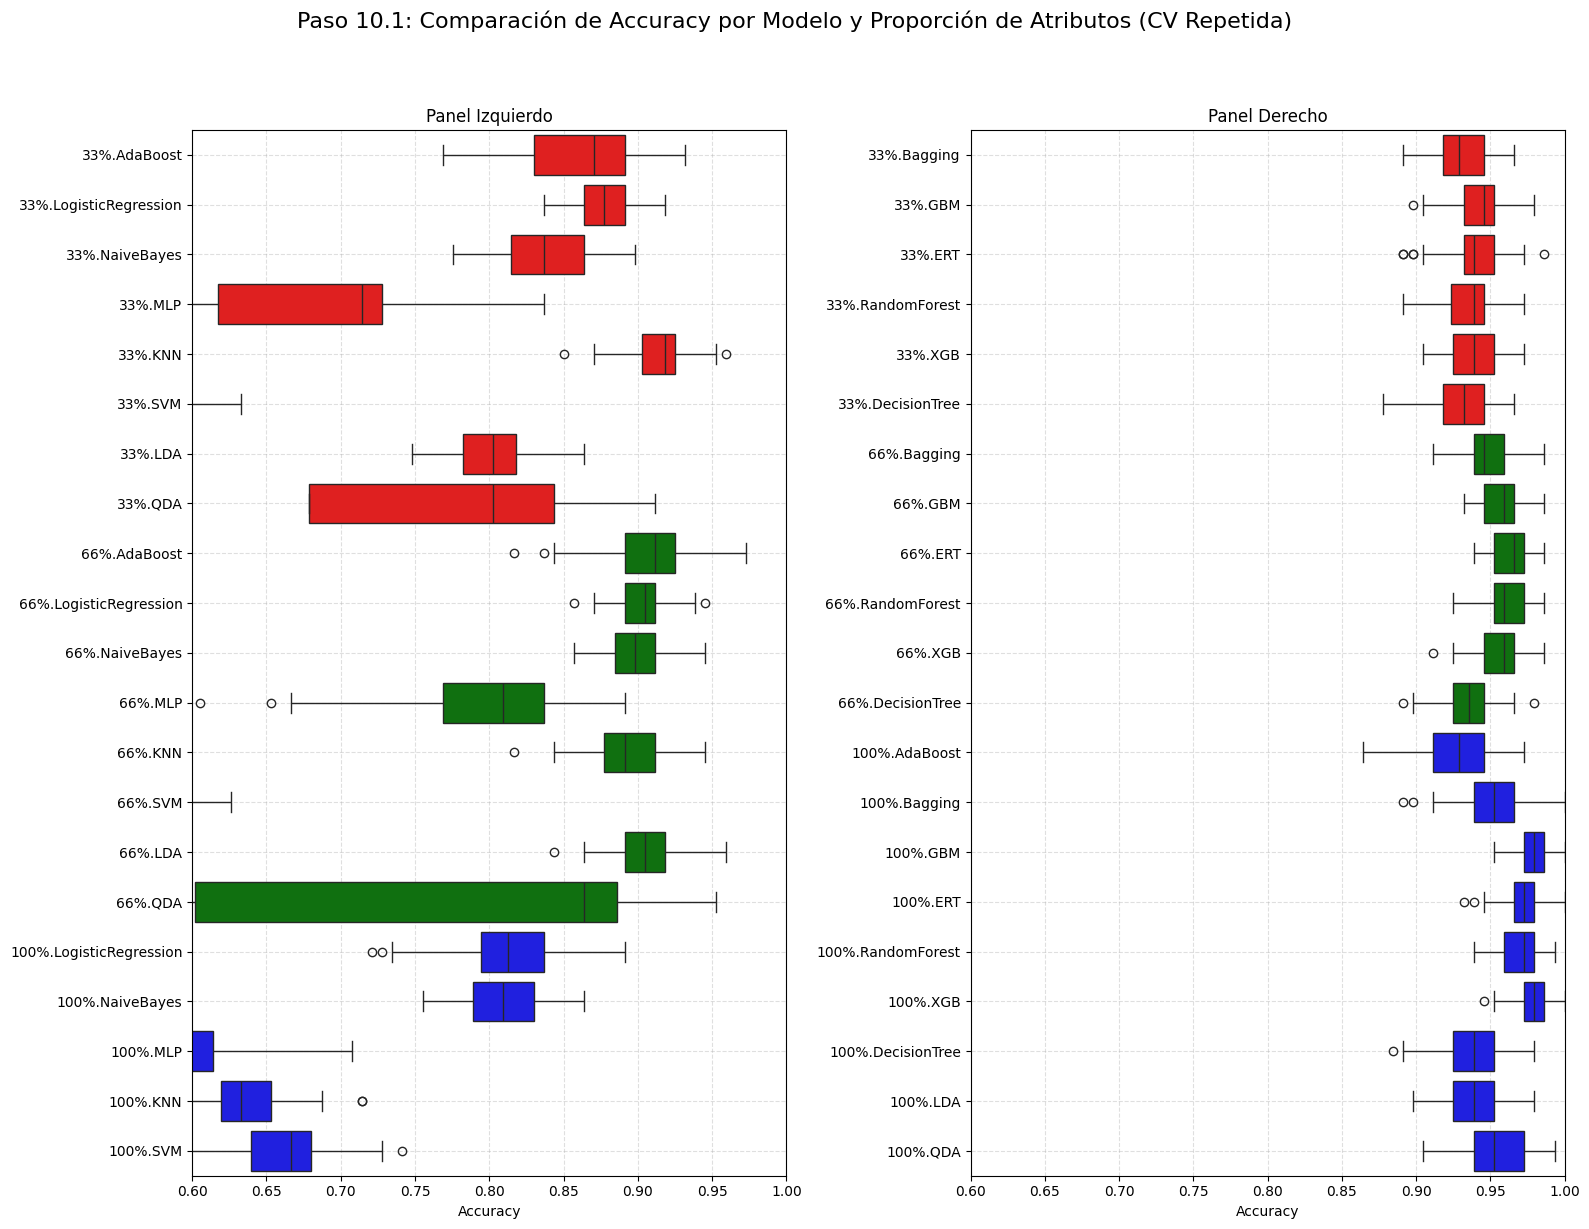

In [20]:

# Paso 10.1 Ajustado: Visualización en panel tipo boxplot para Accuracy con CV Repetida
import matplotlib.gridspec as gridspec

# Preparar etiquetas combinadas y colores por grupo
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33%': 'red', '66%': 'green', '100%': 'blue'})

# Ordenar etiquetas por Accuracy promedio
sorted_labels = df_results_all.groupby('Label')['accuracy'].mean().sort_values().index.tolist()

# Crear figura con dos paneles
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

# Dividir etiquetas en dos paneles
half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]

    sns.boxplot(
        data=subset,
        y='Label',
        x='accuracy',
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33%': 'red', '66%': 'green', '100%': 'blue'}
    )
    ax.set_xlim(0.6, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Panel {"Izquierdo" if i == 0 else "Derecho"}')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend_.remove()

plt.suptitle("Paso 10.1: Comparación de Accuracy por Modelo y Proporción de Atributos (CV Repetida)", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()



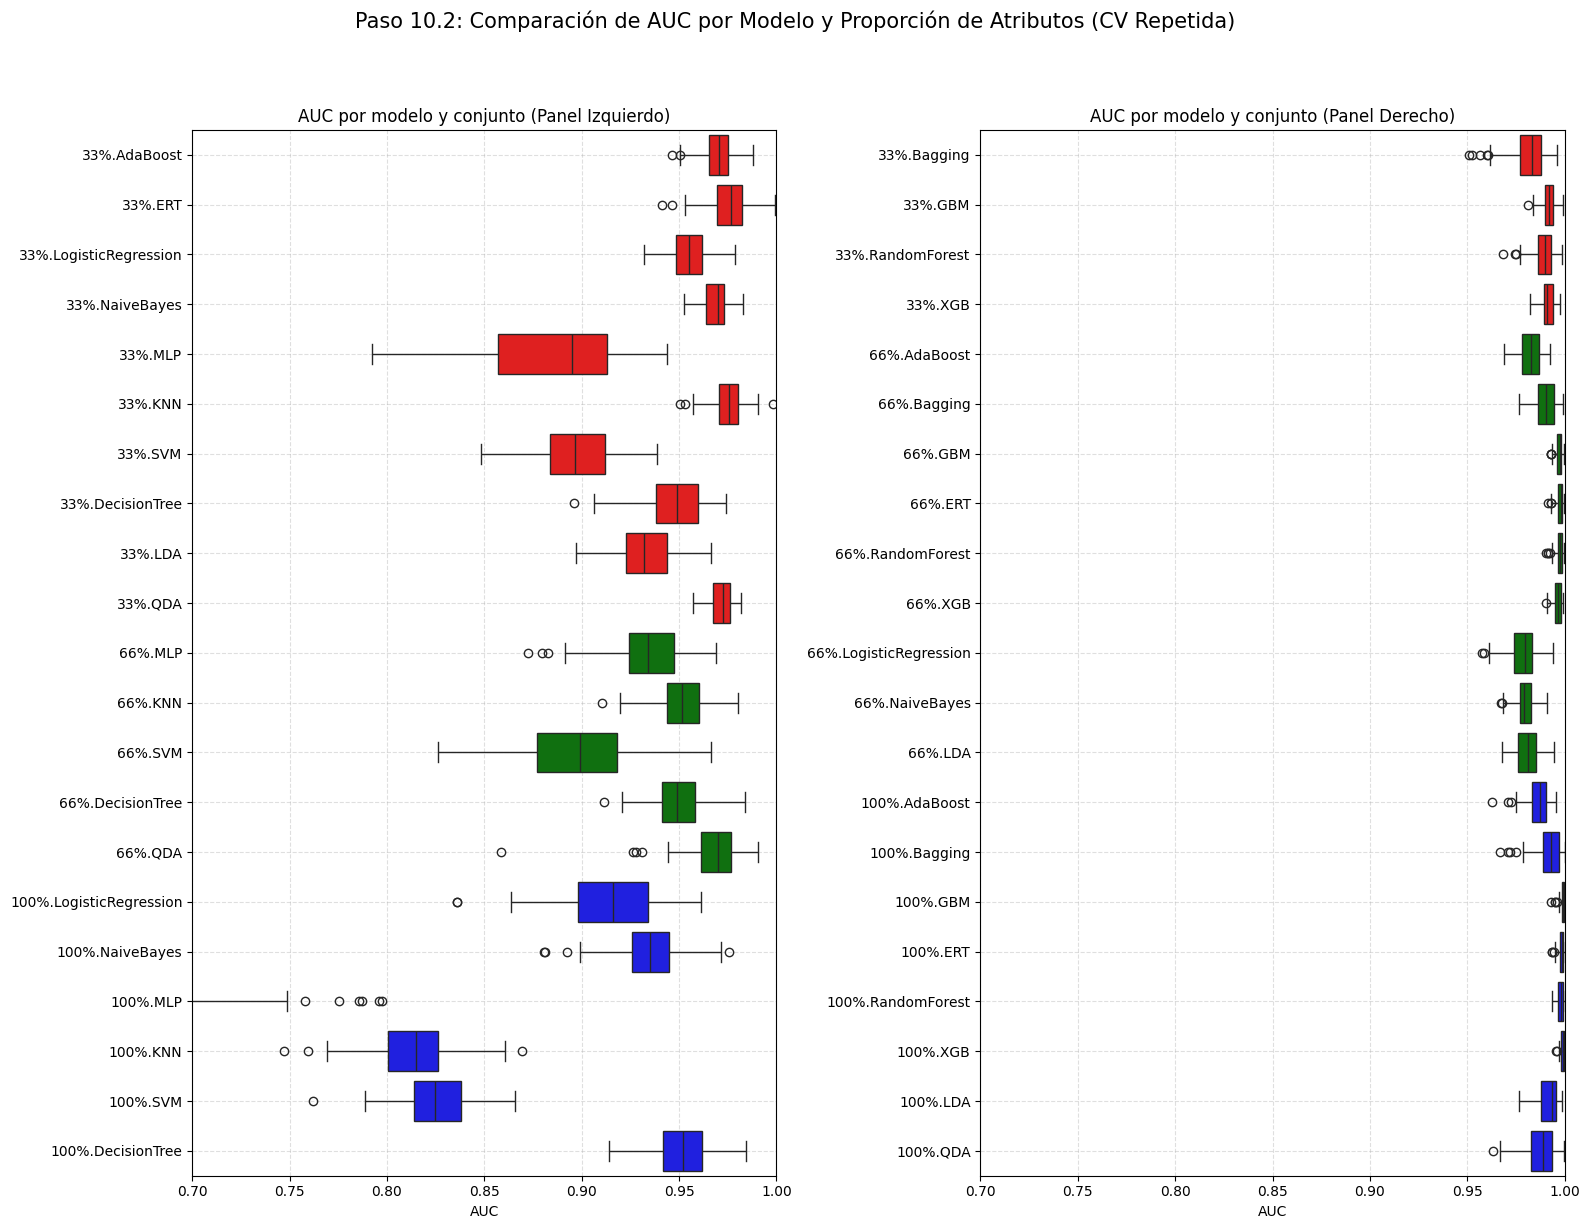

In [21]:
import matplotlib.gridspec as gridspec

# Paso 10.2: Visualización tipo panel con AUC por modelo y proporción de atributos

# Etiquetas correctas
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33%': 'red', '66%': 'green', '100%': 'blue'})

# Ordenar etiquetas por AUC promedio
metric = 'auc'  # minúscula, como viene de repeated_cv_metrics
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index.tolist()

# Crear figura dividida en dos paneles
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

# Separar etiquetas para mostrar en dos paneles
half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]

    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33%': 'red', '66%': 'green', '100%': 'blue'}
    )
    ax.set_xlim(0.7, 1.0)
    ax.set_xlabel('AUC')
    ax.set_ylabel('')
    ax.set_title(f'AUC por modelo y conjunto ({ "Panel Izquierdo" if i == 0 else "Panel Derecho" })')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend_.remove()

plt.tight_layout()
plt.suptitle("Paso 10.2: Comparación de AUC por Modelo y Proporción de Atributos (CV Repetida)", fontsize=15, y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()

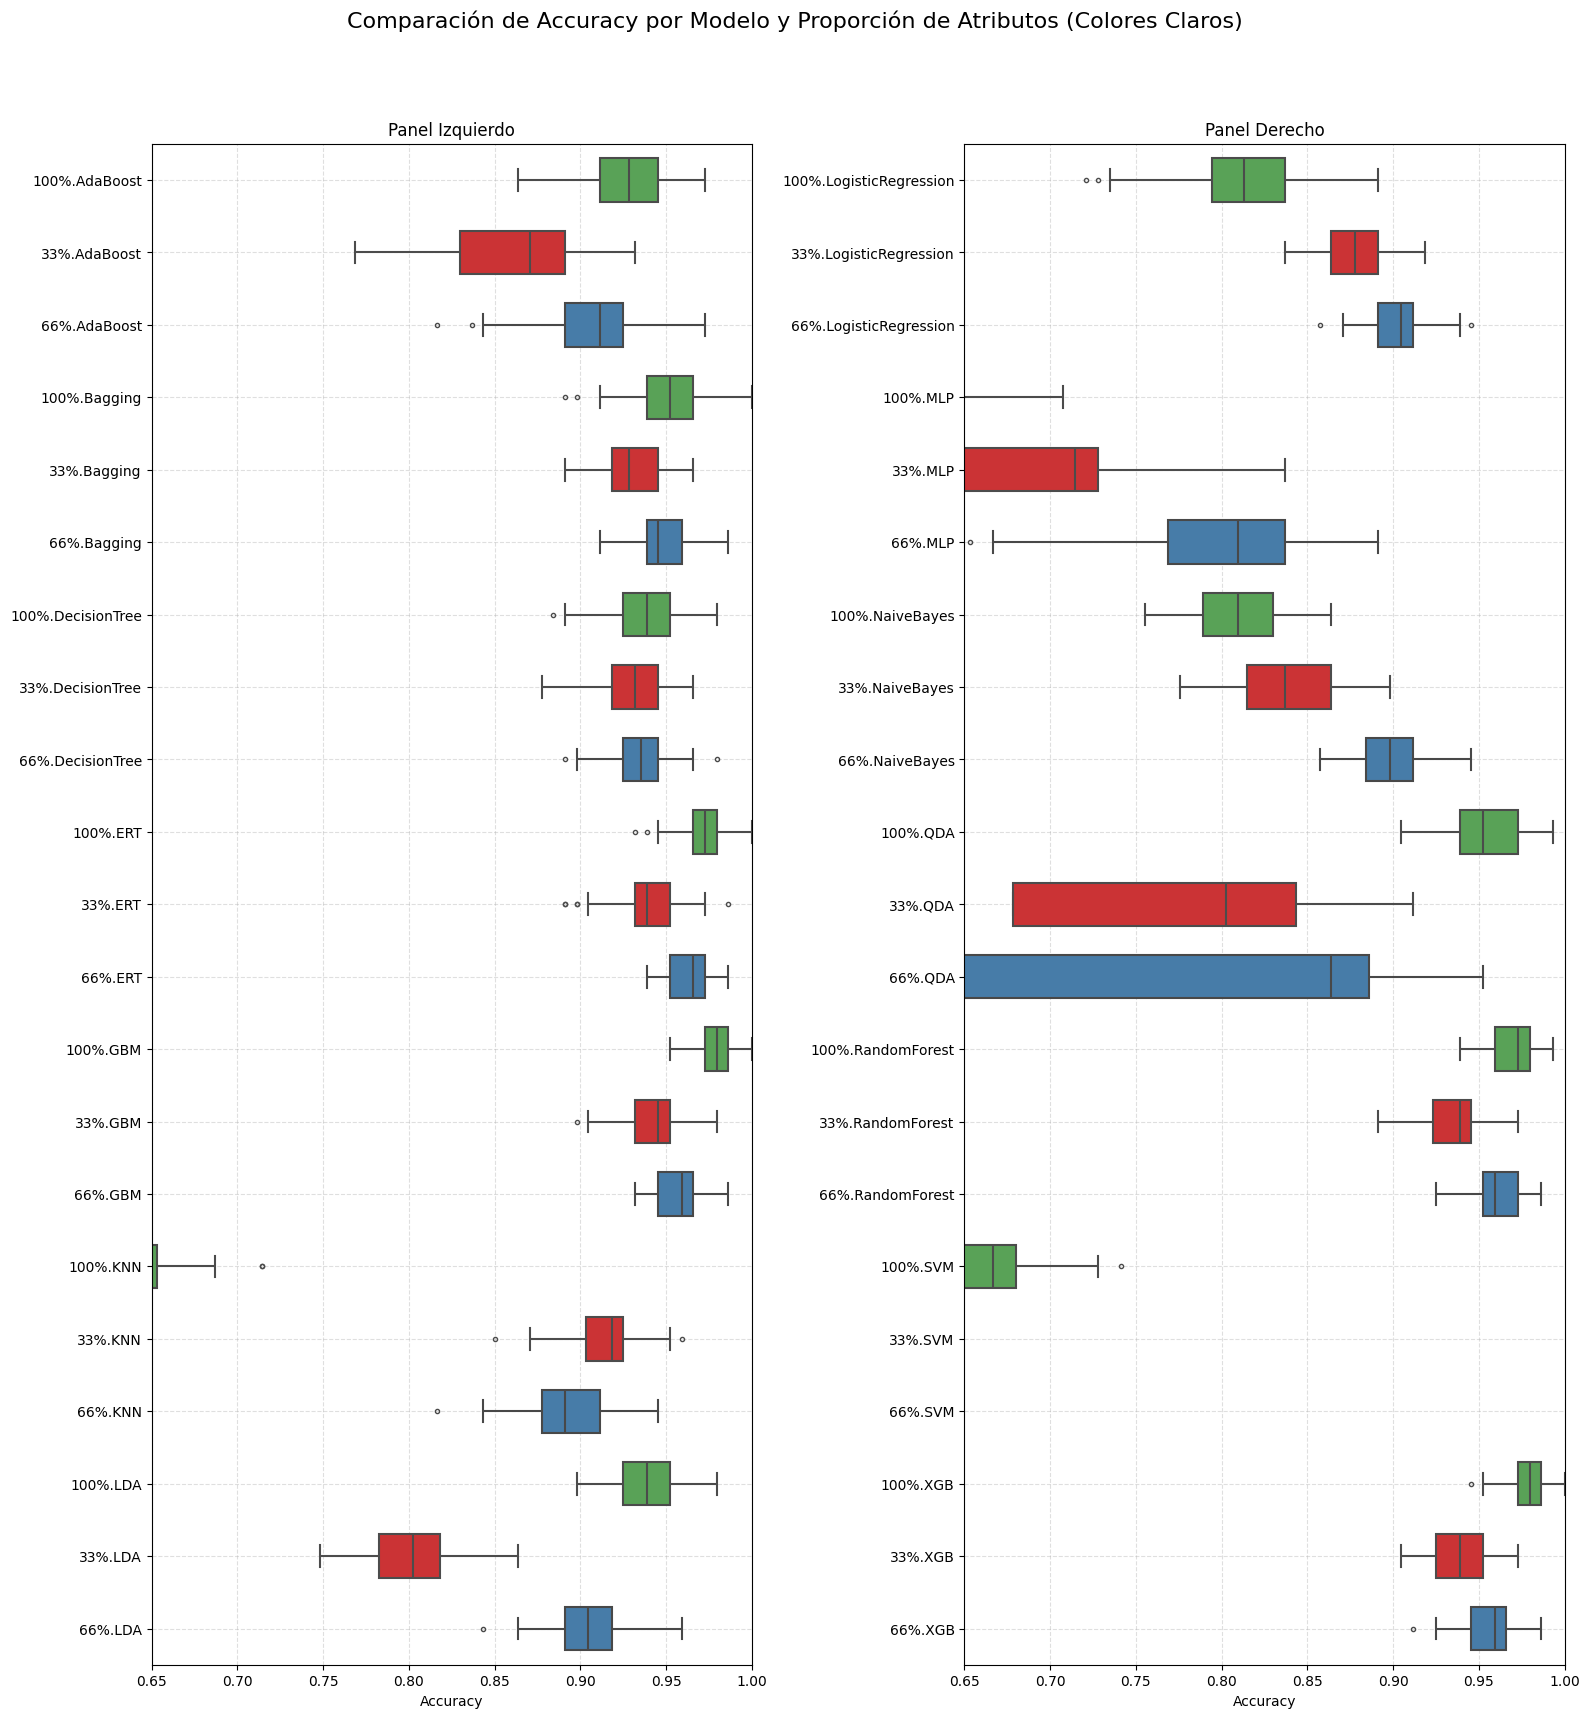

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Colores personalizados por subconjunto
palette_map = {'33%': '#E41A1C', '66%': '#377EB8', '100%': '#4DAF4A'}

# Asegurar etiquetas y orden
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
sorted_labels = sorted(
    df_results_all['Label'].unique(),
    key=lambda x: (x.split('.')[1], x.split('.')[0])  # por modelo, luego subconjunto
)

# Separar en 2 paneles
cols = 2
half = len(sorted_labels) // cols + len(sorted_labels) % cols
label_splits = [sorted_labels[:half], sorted_labels[half:]]

# Figura
fig = plt.figure(figsize=(16, len(sorted_labels) * 0.4))
gs = gridspec.GridSpec(1, cols, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

for i, ax in enumerate(axs):
    labels = label_splits[i]
    subset = df_results_all[df_results_all['Label'].isin(labels)]

    # Para asegurar colores, graficamos cada subconjunto por separado
    for attr_value, color in palette_map.items():
        sub_attr = subset[subset['attr'] == attr_value]
        sns.boxplot(
            data=sub_attr,
            x='accuracy',
            y='Label',
            orient='h',
            order=labels,
            ax=ax,
            width=0.6,
            linewidth=1.5,
            fliersize=3,
            color=color
        )

    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("")
    ax.set_title("Panel Izquierdo" if i == 0 else "Panel Derecho")
    ax.grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Comparación de Accuracy por Modelo y Proporción de Atributos (Colores Claros)", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()



In [23]:
# Análisis de Curvas de Rashomon con Múltiples Conjuntos de Atributos

import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd

warnings.filterwarnings('ignore')

# Supuestos: variables disponibles
# X, y, ranking_df, models

# Definición de subconjuntos de atributos
total_features = len(ranking_df)
feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(round(0.33 * total_features)).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(round(0.66 * total_features)).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC    

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)
                if y_prob.shape[1] > 1:
                    from sklearn.preprocessing import label_binarize
                    y_bin = label_binarize(y_valid_r, classes=list(range(y_prob.shape[1])))
                    auc = roc_auc_score(y_bin, y_prob, average='macro')
                else:
                    auc = roc_auc_score(y_valid_r, y_prob[:, 0])
            except:
                auc = roc_auc_score(y_valid_r, y_pred)

            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            elif hasattr(model, 'estimators_'):
                complexity = sum([est.tree_.node_count for est in model.estimators_])
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)    
rashomon_df

Subset               Model       AUC  TrainingTime  Complexity   BestAUC  \
0    top33            AdaBoost  0.984774      0.109473   50.000000  0.997295   
1    top33             Bagging  0.981390      0.028703   10.000000  0.997295   
2    top33                 GBM  0.997295      0.578156  100.000000  0.997295   
3    top33                 ERT  0.996103      0.120129  100.000000  0.997295   
4    top33        RandomForest  0.995598      0.191501  100.000000  0.997295   
5    top33                 XGB  0.996470      0.146438         NaN  0.997295   
6    top33  LogisticRegression  0.979273      0.365036    9.000000  0.997295   
7    top33          NaiveBayes  0.975661      0.002985    0.002985  0.997295   
8    top33                 MLP  0.877980      0.120554  100.000000  0.997295   
9    top33                 KNN  0.970768      0.002396    0.002396  0.997295   
10   top33                 SVM  0.865996      0.040306    0.040306  0.997295   
11   top33        DecisionTree  0.946603      0.003461    7.000000  0.997295   
12   top33                 LDA  0.973577      0.002025    9.000000  0.997295   
13   top33                 QDA  0.964267      0.002404    0.002404  0.997295   
14   top66            AdaBoost  0.986735      0.133365   50.000000  0.999786   
15   top66             Bagging  0.994091      0.045217   10.000000  0.999786   
16   top66                 GBM  0.999282      0.936693  100.000000  0.999786   
17   top66                 ERT  0.998429      0.122102  100.000000  0.999786   
18   top66        RandomForest  0.997686      0.190803  100.000000  0.999786   
19   top66                 XGB  0.999786      0.155791         NaN  0.999786   
20   top66  LogisticRegression  0.951634      0.307477   18.000000  0.999786   
21   top66          NaiveBayes  0.913542      0.002029    0.002029  0.999786   
22   top66                 MLP  0.744570      0.076278  100.000000  0.999786   
23   top66                 KNN  0.849211      0.001003    0.001003  0.999786   
24   top66                 SVM  0.723906      0.039382    0.039382  0.999786   
25   top66        DecisionTree  0.967993      0.004671    7.000000  0.999786   
26   top66                 LDA  0.990170      0.002084   18.000000  0.999786   
27   top66                 QDA  0.845672      0.001871    0.001871  0.999786   
28  top100            AdaBoost  0.990969      0.164840   50.000000  0.999713   
29  top100             Bagging  0.991486      0.058972   10.000000  0.999713   
30  top100                 GBM  0.999713      1.337378  100.000000  0.999713   
31  top100                 ERT  0.998965      0.125088  100.000000  0.999713   
32  top100        RandomForest  0.999146      0.210521  100.000000  0.999713   
33  top100                 XGB  0.999642      0.173701         NaN  0.999713   
34  top100  LogisticRegression  0.942545      0.358541   27.000000  0.999713   
35  top100          NaiveBayes  0.912337      0.002198    0.002198  0.999713   
36  top100                 MLP  0.663118      0.044208  100.000000  0.999713   
37  top100                 KNN  0.821545      0.001104    0.001104  0.999713   
38  top100                 SVM  0.831563      0.054737    0.054737  0.999713   
39  top100        DecisionTree  0.957298      0.007571    7.000000  0.999713   
40  top100                 LDA  0.992730      0.005809   27.000000  0.999713   
41  top100                 QDA  0.984708      0.002179    0.002179  0.999713   

    RashomonVolume  WithinEpsilon  
0                4          False  
1                4          False  
2                4           True  
3                4           True  
4                4           True  
5                4           True  
6                4          False  
7                4          False  
8                4          False  
9                4          False  
10               4          False  
11               4          False  
12               4          False  
13               4          False  
14               6     

In [24]:

# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)

def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")
pareto_df[pareto_df['ParetoFront']]


Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


Subset               Model       AUC  TrainingTime  Complexity   BestAUC  \
0    top33            AdaBoost  0.984774      0.109473   50.000000  0.997295   
1    top33             Bagging  0.981390      0.028703   10.000000  0.997295   
2    top33                 GBM  0.997295      0.578156  100.000000  0.997295   
5    top33                 XGB  0.996470      0.146438         NaN  0.997295   
6    top33  LogisticRegression  0.979273      0.365036    9.000000  0.997295   
7    top33          NaiveBayes  0.975661      0.002985    0.002985  0.997295   
9    top33                 KNN  0.970768      0.002396    0.002396  0.997295   
15   top66             Bagging  0.994091      0.045217   10.000000  0.999786   
16   top66                 GBM  0.999282      0.936693  100.000000  0.999786   
19   top66                 XGB  0.999786      0.155791         NaN  0.999786   
21   top66          NaiveBayes  0.913542      0.002029    0.002029  0.999786   
23   top66                 KNN  0.849211      0.001003    0.001003  0.999786   
25   top66        DecisionTree  0.967993      0.004671    7.000000  0.999786   
29  top100             Bagging  0.991486      0.058972   10.000000  0.999713   
30  top100                 GBM  0.999713      1.337378  100.000000  0.999713   
33  top100                 XGB  0.999642      0.173701         NaN  0.999713   
37  top100                 KNN  0.821545      0.001104    0.001104  0.999713   
40  top100                 LDA  0.992730      0.005809   27.000000  0.999713   
41  top100                 QDA  0.984708      0.002179    0.002179  0.999713   

    RashomonVolume  WithinEpsilon  ParetoFront  
0                4          False         True  
1                4          False         True  
2                4           True         True  
5                4           True         True  
6                4          False         True  
7                4          False         True  
9                4          False         True  
15               6           True         True  
16               6           True         True  
19               6           True         True  
21               6          False         True  
23               6          False         True  
25               6          False         True  
29               7           True         True  
30               7           True         True  
33               7           True         True  
37               7          False         True  
40               7           True         True  
41               7          False         True

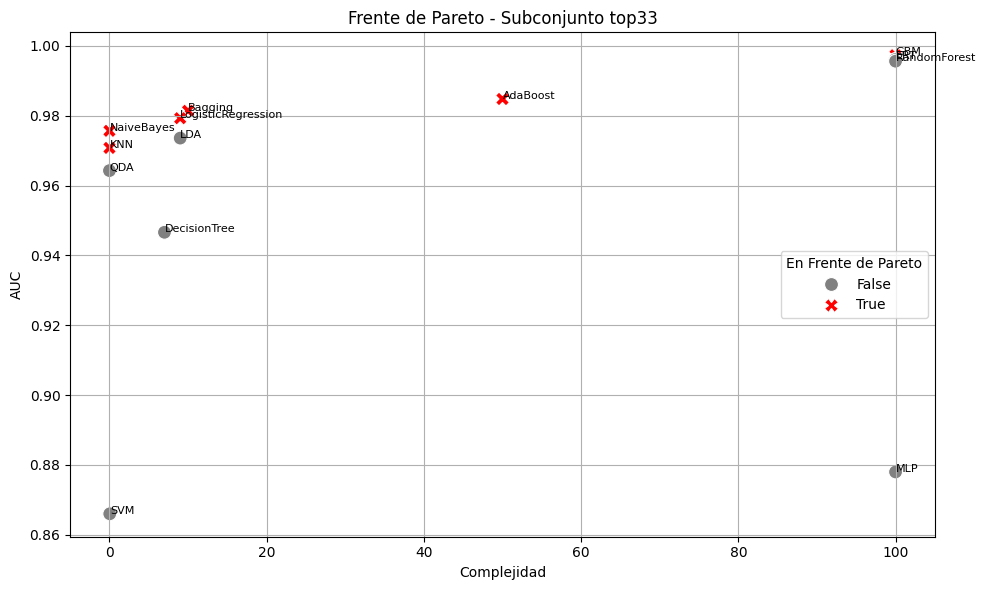

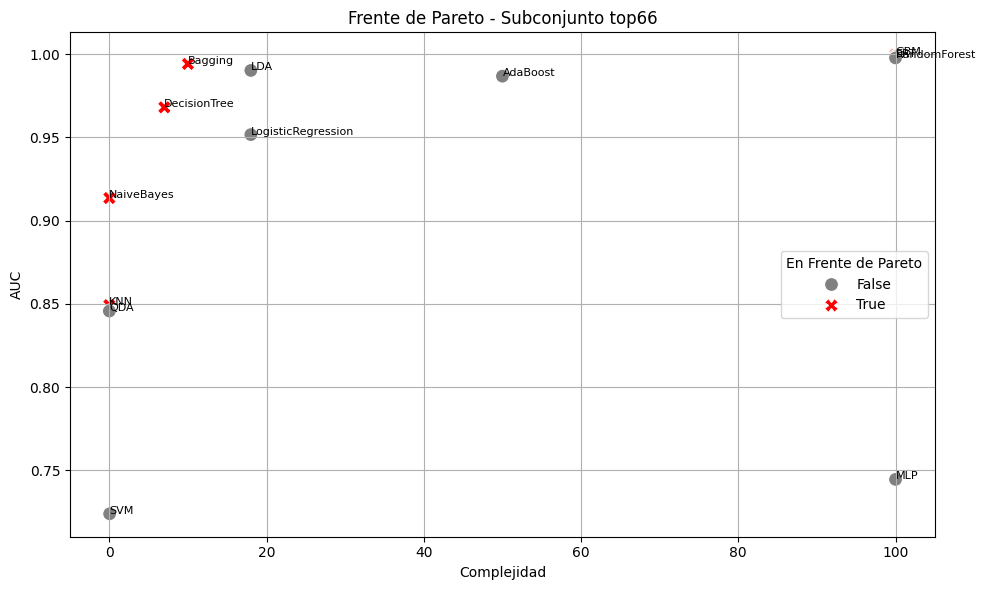

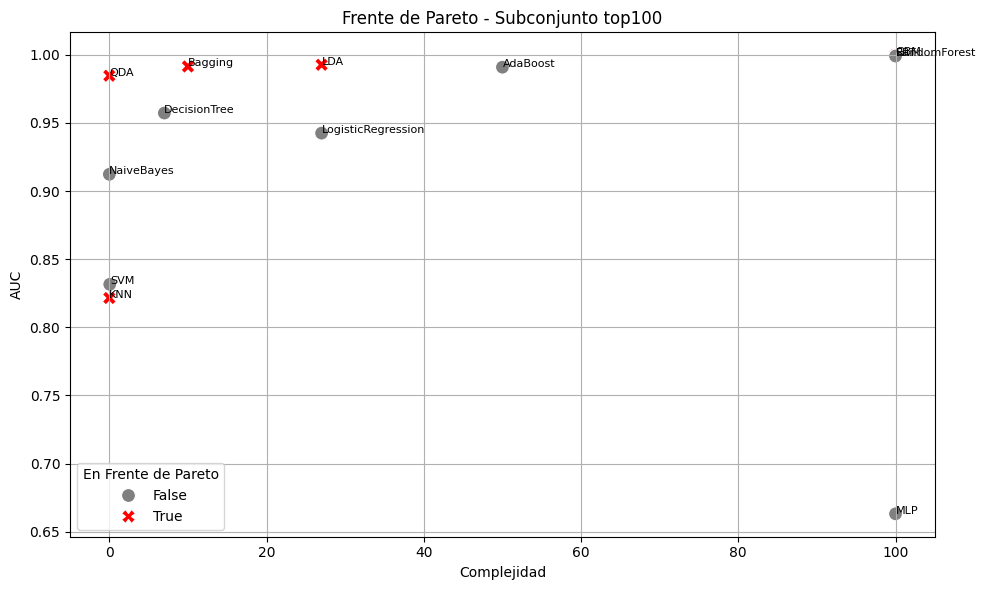

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()